# notebook for generation of EPSP graphs from combining genes->STP data


1) Load ABA VISp,Hipp gene expression and STP data . 

2) Plot EPSPs for different synapse types



In [82]:
import pandas as pd
import numpy as np


do_laptop=1   # Laptop or desctop version


#do_add_scvi_latent_factors = 1
#do_add_scvi_imputed_genes = 1

do_replace_to_scVI_imputed=1      # replace raw gene expression data with their scvi imputation
do_add_scvi_latent_factors=1      # add scvi latent factors data
do_use_all_scvi_genes=1           # use all scvi genes expression in addition to pregs, postgs

gs_name = '_gs5188' #'_gs1512' #'_gs15656' #'_gs5188' #'_gs1512' #'_gs219'

In [87]:
# Solar system:
r=np.array([68,108,147,226,763,1491,2958,4476])
d=np.array([4800,12000,13000,6500,130000,120000,49000,51000])

In [88]:
print(d*2/13000)
r2=r*4/68
r2

[ 0.73846154  1.84615385  2.          1.         20.         18.46153846
  7.53846154  7.84615385]


array([  4.        ,   6.35294118,   8.64705882,  13.29411765,
        44.88235294,  87.70588235, 174.        , 263.29411765])

# load combined-stp data


In [2]:
def  STP_sim(ge_data, T, init_state=None ):
    # transform labels from TM to An:A1
    #f = 20 # Hz
    #N = 3
    #T = np.arange(N)*1000/f

    N    = len(T)
    nc   = len(ge_data.index)

    x_lower = np.array([1,       0.01,    1,      0.1,     1])
    x_upper = np.array([10000,   1,      10000,    10,     1])
    stp_ns =          ['tF',    'p0',    'tD',   'dp/p0', 'A']
    for jj in range(len(stp_ns)):
        nsj = stp_ns[jj]
        ge_data.loc[:,nsj] = np.maximum(ge_data.loc[:,nsj].values,x_lower[jj])
        ge_data.loc[:,nsj] = np.minimum(ge_data.loc[:,nsj].values,x_upper[jj])
        if nsj=='dp/p0':
            p0   = ge_data.loc[:,'p0'].values
            dpp0 = ge_data.loc[:,'dp/p0'].values
            dp = p0*dpp0
            dp = np.minimum(dp,1)
            ge_data.loc[:,nsj] = dp/(p0 +np.finfo(float).eps)

    dpp0 = ge_data.loc[:,'dp/p0'].values
    p0   = ge_data.loc[:,'p0'].values
    tF   = ge_data.loc[:,'tF'].values
    tD   = ge_data.loc[:,'tD'].values
    A    = 1 + 0*ge_data.loc[:,'A'].values # simplify A

    As = np.zeros((nc,N))
    n = np.zeros((nc,))
    p = np.zeros((nc,))
    ns2 = np.zeros((nc,N))
    ps2 = np.zeros((nc,N))

    i=0
    
    if init_state is None :
        n[:] = 1
        p[:] = p0
    else:
        n = init_state[0]
        p = init_state[1]


    As[:,i] = A*n*p
    
    n = n*(1-p)
    p = p + dp*(1-p)
    
    ns2[:,i]=n
    ps2[:,i]=p

    for i in range(1,N):
        Dt=T[i]-T[i-1]
        #n = 1 - (1 - (n -p*n))*np.exp((-Dt/tD).astype(float))
        #p=p0 -(p0-(p + dpp0*p0*(1-p)))*np.exp((-Dt/tF).astype(float))
        #As[:,i]=A*n*p
        #ns2[:,i]=n
        #ps2[:,i]=p

        
        n = 1 - (1 - n )*np.exp((-Dt/tD ).astype(float))
        p=p0 +(p -p0)*np.exp((-Dt/tF).astype(float))
            

        As[:,i]=A*n*p
       
        n = n*(1-p)
        p = p + dp*(1-p)
        
        ns2[:,i]=n
        ps2[:,i]=p

    

    #aa = [As, ns2, ps2]
    
    return As, ns2, ps2, dpp0, p0, tF, tD, A

In [3]:
def  STP_sim2(x, T, init_state=None, model_type='tm5' ):

    N    = len(T)
    tF      = x[0] #.astype(float)
    p00     = x[1]
    tD      = x[2] #.astype(float)
    dp      = x[3]
    A       = 1 #x[4] # simplify A
    
    #breakpoint()
    mod_fdr2=False
    if model_type=='tm5_fdr2':  # should be :check freq. dependent recovery
        tDmin     = x[5]
        dd        = x[6]
        t_FDR     = x[7]
        mod_fdr2=True
        tDmax  = tD
        itDmin = 1/tDmin
        itDmax = 1/tDmax
        #breakpoint()
        
    mod_smr=False
    if model_type=='tm5_smr':  # should be :check freq. dependent recovery
        t_SMR   = x[8]
        dp0     = x[9]
        mod_smr=True
        #p00  = p00

    As = np.zeros((N,))
    state = np.zeros((N,4))

   
    if init_state is None :
        n = 1
        p0=p00
        p = p0
        d = 0
    else:
        n = init_state[0]
        p = init_state[1]
        d = init_state[2]
        p0= init_state[3]

    
    for i in range(0,N):
        if i==0:
            Dt = T[i]
        else:
            Dt = T[i]-T[i-1]
        
        if mod_fdr2:
            d0=d
            d = d*np.exp(-Dt/t_FDR) 
            n = 1 - (1 - n )*np.exp(-Dt*itDmax -(itDmin -itDmax)*t_FDR*(d0-d))
        else:
            n = 1 - (1 - n )*np.exp(-Dt/tD )
            
        if mod_smr:
            p01=p0
            p0=p00 + (p0 -p00)*np.exp(-Dt/t_SMR)
            p=p0 +(p -p01)*np.exp(-Dt/tF)
        else:
            p=p0 +(p -p0)*np.exp(-Dt/tF)
            

        As[i]=A*n*p
       
        n = n*(1-p)
        p = p + dp*(1-p)
        if mod_fdr2:
            d  = d + dd*(1-d) 
        if mod_smr:
            p0  = p0 - dp0*p0    
 
        state[i] = [n,p,d,p0]

    #return As, ns2, ps2, dpp0, p0, tF, tD, A
    return As, state

In [4]:
def STP_sim_complex(ge_data,l_pre_post2,stp_aba_names):
    # transform labels from TM to An:A1
    #fs = [20, 50, 10] # Hz
    fs = [20, 50, 10]
    N = 5

    #Trec = [250, 500, 1000]
    Trec =[250, 1000]
    DT0 = 25000
    if l_pre_post2<ge_data.shape[0]:
        xs  =ge_data.iloc[l_pre_post2:,:].loc[:,stp_aba_names].values
        xs  =np.delete(xs, [5,6],axis=1)
        As2=np.zeros((xs.shape[0],0))
    
    
    As=np.zeros((l_pre_post2,0))
    if 1:

        for f in fs:
            T = np.arange(N)*1000/f

            if l_pre_post2>0:
                Asf, ns, ps, dpp0, p0, tF, tD, A = STP_sim(ge_data.iloc[0:l_pre_post2,:],T)
                As = np.concatenate([As,Asf],axis=1)

                for ri in range(len(Trec)):
                    Asr, nsr, psr, dpp0, p0, tF, tD, A = STP_sim(ge_data.iloc[0:l_pre_post2,:],[Trec[ri]],init_state=[ns[:,-1],ps[:,-1]])
                    As = np.concatenate([As,Asr],axis=1)

            if l_pre_post2<ge_data.shape[0]:
                As2f = np.zeros((xs.shape[0],N+len(Trec)))
                for i2 in range(xs.shape[0]):
                    #as2, sts2 = STP_sim2(xs[i2,:],np.arange(8)*50,model_type = 'tm5') # preconditioning series???
                    #as2, sts2 = STP_sim2(xs[i2,:], T+DT0, init_state=sts2[-1], model_type='tm5' ) 

                    as2, sts2 = STP_sim2(xs[i2,:],T,model_type = 'tm5_smr')

                    As2f[i2,0:N] = as2
                    for ri in range(len(Trec)):
                        as2r, sts2r = STP_sim2(xs[i2,:], [Trec[ri]], init_state=sts2[-1], model_type='tm5_smr' ) 
                        As2f[i2,N+ri] = as2r

                As2 = np.concatenate([As2,As2f],axis=1)

        if l_pre_post2<ge_data.shape[0]:
            As2 = As2/As2[:,0].reshape((-1,1))
        else:
            As2  = np.zeros((0,As.shape[1]))
        
        
        if l_pre_post2>0:
            As = As/As[:,0].reshape((-1,1))
            As = np.concatenate([As,As2],axis=0)
        else:
            As =As2
    else:
        As, ns, ps, dpp0, p0, tF, tD, A = STP_sim(ge_data,T)


    #import matplotlib.pyplot as plt    
    #plt.plot(As2[400:410,:].transpose(),'o-')
    
    return As

### load hippocampus genes->STP

In [71]:
import time
do_load_temporary=1
if do_load_temporary==1:
    t1=time.time()
    print('load ge_data_h...')
    ge_data_h = pd.read_hdf('ge_data_h'+gs_name+'.hdf',key='data')
    t2=time.time()
    print('Elapsed time ',t2-t1, ' s')
    print('load X_h...')
    t1=time.time()
    X_h = pd.read_hdf('X_h'+gs_name+'.hdf',key='data')
    t2=time.time()
    print('Elapsed time ',t2-t1, ' s')
    print('load y_h...')
    y_h = pd.read_hdf('y_h'+gs_name+'.hdf',key='data') 
    print('load annot_columns_h...')
    annot_columns_h=pd.read_excel('annot_columns_h'+gs_name+'.xlsx')
    print('load ge_columns_h...')
    ge_columns_h=pd.read_excel('ge_columns_h'+gs_name+'.xlsx')
    print('load stp_columns_h...')
    stp_columns_h=pd.read_excel('stp_columns_h'+gs_name+'.xlsx')

load ge_data_h...
Elapsed time  1.6343722343444824  s
load X_h...
Elapsed time  72.61632204055786  s
load y_h...
load annot_columns_h...
load ge_columns_h...
load stp_columns_h...


In [81]:
import time
do_load_temporary=1
if do_load_temporary==1:
    t1=time.time()
    print('load ge_data_c...')
    ge_data = pd.read_hdf('ge_data_c'+gs_name+'.hdf',key='data')
    t2=time.time()
    print('Elapsed time ',t2-t1, ' s')
    print('load X_c...')
    t1=time.time()
    X_c = pd.read_hdf('X_c'+gs_name+'.hdf',key='data')
    t2=time.time()
    print('Elapsed time ',t2-t1, ' s')
    print('load y_c...')
    y_c = pd.read_hdf('y_c'+gs_name+'.hdf',key='data') 
    print('load annot_columns_c...')
    annot_columns=pd.read_excel('annot_columns_c'+gs_name+'.xlsx')
    print('load ge_columns_c...')
    ge_columns=pd.read_excel('ge_columns_c'+gs_name+'.xlsx')
    print('load stp_columns_c...')
    stp_columns=pd.read_excel('stp_columns_c'+gs_name+'.xlsx')
        

load ge_data_c...
Elapsed time  0.5592379570007324  s
load X_c...
Elapsed time  115.68236088752747  s
load y_c...
load annot_columns_c...
load ge_columns_c...
load stp_columns_c...


In [61]:
do_add_aba_synphys = True
stp_aba_names = ['tF', 'p0','tD','dp','A','A1','A2','tDmin','dd','t_FDR','t_SMR','dp0'] # tm5+smr
l_pre_post2 = ge_data.shape[0]

In [80]:
ge_columns = ge_columns.values.ravel().tolist()
annot_columns = annot_columns.values.ravel().tolist()
stp_columns = stp_columns.values.ravel().tolist()
y_c = y_c.values #to_numpy()
X_c = X_c.values #to_numpy()

AttributeError: 'list' object has no attribute 'values'

In [72]:
ge_columns_h = ge_columns_h.values.ravel().tolist()
annot_columns_h = annot_columns_h.values.ravel().tolist()
stp_columns_h = stp_columns_h.values.ravel().tolist()
y_h = y_h.values #to_numpy()
X_h = X_h.values #to_numpy()

In [73]:
#df_aba_vis_in_c.columns
len(ge_columns_h)

10424

In [74]:
print(ge_data_h.shape)
print(X_h.shape)
print(y_h.shape)
print(len(annot_columns_h))
print(len(ge_columns_h))
print(len(stp_columns_h))
print(ge_columns_h[300:])
print(ge_columns_h[0:10])

(8000, 10451)
(8000, 10427)
(8000, 29)
9
10424
20
['pre__Ap4e1', 'pre__Apaf1', 'pre__Apba1', 'pre__Apba2', 'pre__Apeh', 'pre__Apex2', 'pre__Aph1b', 'pre__Aplf', 'pre__Apln', 'pre__Apoe', 'pre__Apold1', 'pre__Apool', 'pre__Appl2', 'pre__Aqp10-ps', 'pre__Ar', 'pre__Arap2', 'pre__Arc', 'pre__Areg', 'pre__Arf6', 'pre__Arfgef2', 'pre__Arfip1', 'pre__Arhgap15', 'pre__Arhgap17', 'pre__Arhgap19', 'pre__Arhgap22', 'pre__Arhgap24', 'pre__Arhgap29', 'pre__Arhgap31', 'pre__Arhgap4', 'pre__Arhgap42', 'pre__Arhgap5', 'pre__Arhgdib', 'pre__Arhgef1', 'pre__Arhgef10', 'pre__Arhgef10l', 'pre__Arhgef11', 'pre__Arhgef12', 'pre__Arhgef15', 'pre__Arhgef16', 'pre__Arhgef17', 'pre__Arhgef18', 'pre__Arhgef19', 'pre__Arhgef2', 'pre__Arhgef26', 'pre__Arhgef3', 'pre__Arhgef33', 'pre__Arhgef4', 'pre__Arhgef5', 'pre__Arhgef6', 'pre__Arhgef7', 'pre__Arhgef9', 'pre__Arid1a', 'pre__Arid1b', 'pre__Arid2', 'pre__Arid3a', 'pre__Arid3b', 'pre__Arid4a', 'pre__Arid4b', 'pre__Arid5a', 'pre__Arid5b', 'pre__Arl13b', 'pre__Arl5

In [75]:
#ge_data_h.to_excel('ge_data_h.xlsx')

##
##
##  CORTEX gene expression
##
##

In [76]:
print(ge_data.shape)
print(X_c.shape)
print(y_c.shape)
print(len(annot_columns))
print(len(ge_columns))
print(len(stp_columns))
print(ge_columns[300:])
print(ge_columns[0:10])

(10600, 10459)
(10600, 10427)
(10600, 29)
9
10424
20
[['pre__Ap4e1'], ['pre__Apaf1'], ['pre__Apba1'], ['pre__Apba2'], ['pre__Apeh'], ['pre__Apex2'], ['pre__Aph1b'], ['pre__Aplf'], ['pre__Apln'], ['pre__Apoe'], ['pre__Apold1'], ['pre__Apool'], ['pre__Appl2'], ['pre__Aqp10-ps'], ['pre__Ar'], ['pre__Arap2'], ['pre__Arc'], ['pre__Areg'], ['pre__Arf6'], ['pre__Arfgef2'], ['pre__Arfip1'], ['pre__Arhgap15'], ['pre__Arhgap17'], ['pre__Arhgap19'], ['pre__Arhgap22'], ['pre__Arhgap24'], ['pre__Arhgap29'], ['pre__Arhgap31'], ['pre__Arhgap4'], ['pre__Arhgap42'], ['pre__Arhgap5'], ['pre__Arhgdib'], ['pre__Arhgef1'], ['pre__Arhgef10'], ['pre__Arhgef10l'], ['pre__Arhgef11'], ['pre__Arhgef12'], ['pre__Arhgef15'], ['pre__Arhgef16'], ['pre__Arhgef17'], ['pre__Arhgef18'], ['pre__Arhgef19'], ['pre__Arhgef2'], ['pre__Arhgef26'], ['pre__Arhgef3'], ['pre__Arhgef33'], ['pre__Arhgef4'], ['pre__Arhgef5'], ['pre__Arhgef6'], ['pre__Arhgef7'], ['pre__Arhgef9'], ['pre__Arid1a'], ['pre__Arid1b'], ['pre__Arid2'], ['pr

In [77]:
import matplotlib.cm as cm

# plot gene expression
print(ge_data.loc[[0,200,400,600,800,1000,1200],annot_columns])
print(postgs)
print(pregs)

apostgs = ['post__'+p for p in postgs]
apostgs = np.array(apostgs)[0:30]
apostgs2 = np.array(postgs)[0:30]
imda = ge_data.loc[1200,apostgs].map(float).values.reshape([1,-1])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

c_orange = np.array([241,132,62])/255
#c_blue = np.array([52,122,175])/255
c_blue = np.array([65,43,93])/255
#cols = np.array( [[1, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]])
cols = np.array( [[65,43,93], [241,132,62], [0, 255, 0]])/255


im = ax.imshow(imda,cmap=cm.RdYlGn)
Dn22=1
# We want to show all ticks...
xD = np.arange(0,apostgs.shape[0])
yD = np.arange(0)
ax.set_xticks(xD)
ax.set_yticks(yD)
# ... and label them with the respective list entries
#ax.set_yticklabels(nms4)
ax.set_xticklabels(apostgs2)
#ax.set_yticklabels(vse_pre2[yD])
#ax.tick_params(axis='x', colors='none')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor", fontsize=16)

#axes.set_ylim(-1, nmm+1)

ax.grid( b=False)

apostgs = ['pre__'+p for p in pregs]
apostgs = np.array(apostgs)[np.arange(0,140,5)]
apostgs2 = np.array(pregs)[np.arange(0,140,5)]
imda = ge_data.loc[1200,apostgs].map(float).values.reshape([1,-1])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

c_orange = np.array([241,132,62])/255
#c_blue = np.array([52,122,175])/255
c_blue = np.array([65,43,93])/255
#cols = np.array( [[1, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]])
cols = np.array( [[65,43,93], [241,132,62], [0, 255, 0]])/255


im = ax.imshow(imda,cmap=cm.RdYlGn)
Dn22=1
# We want to show all ticks...
xD = np.arange(0,apostgs.shape[0])
yD = np.arange(0)
ax.set_xticks(xD)
ax.set_yticks(yD)
# ... and label them with the respective list entries
#ax.set_yticklabels(nms4)
ax.set_xticklabels(apostgs2)
#ax.set_yticklabels(vse_pre2[yD])
#ax.tick_params(axis='x', colors='none')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor", fontsize=16)

#axes.set_ylim(-1, nmm+1)

ax.grid( b=False)



KeyError: KeyError("None of [Index([ ('cell_type2_pre',), ('cell_type2_post',),       ('layer_pre',),\n            ('layer_post',),    ('cre_line_pre',),   ('cre_line_post',),\n              ('index_ds',),     ('samples_pre',),    ('samples_post',)],\n      dtype='object')] are in the [columns]")

In [51]:
import scipy as sci
def epsp_sim(A, T_A,dt,tplus,tminus,Tmax):
    
    l, v = sci.linalg.eig(np.array([[-1/tplus,0],[1/tplus,-1/tminus]])) 
    l = np.real(l).reshape([-1,1])
    vm = sci.linalg.inv(v)
    #x = v*np.exp(l*t)*np.array([1,0]).reshape([-1,1])                  
    X = np.array([0,0]).reshape([-1,1])

    t=np.array([0])
    for i in np.arange(1,T_A.size):
        if T_A[i]-T_A[i-1]>Tmax+10*dt:
            t2  =  np.arange(int(Tmax/dt))[np.newaxis]*dt  
            t3  =  - 10*dt + np.arange(10)[np.newaxis]*dt   
            
            t5 = np.append(t2,t3+Tmax+10*dt ,axis=1)
            t2 = np.append(t2,t3+T_A[i] - T_A[i-1],axis=1)

        else: 
            t2  =  np.arange(int((T_A[i]-T_A[i-1])/dt))[np.newaxis]*dt 
            t5 = t2

        #print(i)    
        x0 = X[:,[-1]]   
        x0[0,:] = x0[0,:]+A[i-1] 
        vvmx=(v@np.diag((vm@x0).ravel()))
        x = vvmx@np.exp(l@t2)
        X = np.append(X,x,axis=1)
        #t = np.append(t,T_A[i-1] +t5)   
        t = np.append(t,t[-1] +t5)   
    
    return X, t

In [52]:

dt=0.1
tplus=0.3
tminus=10
Tmax = 100
A = np.array([0,2,3,4,5,0])
T_A = np.array([0,200,250,300,550,650])

X, t = epsp_sim(A, T_A,dt,tplus,tminus,Tmax)
    
f, ax =plt.subplots(figsize=(sx, sy))
plt.plot(t,X.T)

f, ax =plt.subplots(figsize=(sx, sy))
plt.plot(X.T)


AttributeError: module 'scipy' has no attribute 'linalg'

In [53]:
l_pre_post23 = 2 #200 #int(200/10)
ge_data_temp = ge_data.iloc[::l_pre_post23,:] #.loc[:,stp_aba_names]

In [54]:
ge_data_temp.shape

(5300, 10459)

In [55]:
#annot_columns2 =np.array(annot_columns)
annot_columns
ge_data_temp.loc[:,annot_columns]

KeyError: "None of [[['cell_type2_pre'], ['cell_type2_post'], ['layer_pre'], ['layer_post'], ['cre_line_pre'], ['cre_line_post'], ['index_ds'], ['samples_pre'], ['samples_post']]] are in the [columns]"

In [56]:

dt=0.1
import matplotlib.pyplot as plt 
%matplotlib inline
# transform labels from TM to An:A1
fs = [20 , 10, 40] # Hz
N = 8

Trec = [250, 1000]
Trec=[]
DT0 = 25000
xs  =ge_data_temp.iloc[:,:].loc[:,stp_aba_names].values
xs  =np.delete(xs, [5,6],axis=1)
#As=np.zeros((l_pre_post2,0))
As=np.zeros((xs.shape[0],0))
As2=np.zeros((xs.shape[0],0))
Tall_A = np.arange(1)
if do_add_aba_synphys:
    
    for f in fs:
        T = np.arange(N)*1000/f
        Tall_A = np.append(Tall_A, T+DT0+Tall_A[-1])
        
        Asf, ns, ps, dpp0, p0, tF, tD, A = STP_sim(ge_data_temp.iloc[0:,:],T)
        As = np.concatenate([As,Asf],axis=1)
        
        for ri in range(len(Trec)):
            Asr, nsr, psr, dpp0, p0, tF, tD, A = STP_sim(ge_data_temp.iloc[0:,:],[Trec[ri]],init_state=[ns[:,-1],ps[:,-1]])
            As = np.concatenate([As,Asr],axis=1)
        Tall_A = np.append(Tall_A, np.array(Trec)+Tall_A[-1])
        

        As2f = np.zeros((xs.shape[0],N+len(Trec)))
        for i2 in range(xs.shape[0]):
            #as2, sts2 = STP_sim2(xs[i2,:],np.arange(8)*50,model_type = 'tm5') # preconditioning series???
            #as2, sts2 = STP_sim2(xs[i2,:], T+DT0, init_state=sts2[-1], model_type='tm5' ) 
            
            as2, sts2 = STP_sim2(xs[i2,:],T,model_type = 'tm5_smr')
            
            As2f[i2,0:N] = as2
            for ri in range(len(Trec)):
                as2r, sts2r = STP_sim2(xs[i2,:], [Trec[ri]], init_state=sts2[-1], model_type='tm5_smr' ) 
                As2f[i2,N+ri] = as2r
                
        As2 = np.concatenate([As2,As2f],axis=1)
            
    
    As2 = As2/As2[:,0].reshape((-1,1))
    As = As/As[:,0].reshape((-1,1))
    Na1 = As.shape[1]
    As = np.concatenate([As,As2],axis=0)
else:
    As, ns, ps, dpp0, p0, tF, tD, A = STP_sim(ge_data,T)
    

sx=10
sy=5
do_this=0
if do_this==1:
    for ii in range(As2.shape[0]):
        f, ax =plt.subplots(figsize=(sx, sy))
        plt.plot(As2[ii,:],'o-',linewidth=4, markersize=12)
        #plt.ylim([0,1.2])
        plt.xticks(fontsize=18)
        plt.xticks(ticks=[0,5,10,15,20],fontsize=18)
        plt.yticks(ticks=[0.5,1.0,1.5],fontsize=18)
        plt.ylabel('An:A1',fontsize=20)
        plt.xlabel('Stimulus number',fontsize=20)
        # cell_type2_pre	cell_type2_post
        str_syn_type = ge_data_temp.iloc[ii,:].loc['cell_type2_pre']+'->'+ge_data_temp.iloc[ii,:].loc['cell_type2_post']
        plt.title(str(ii)+' '+str_syn_type)
        #plt.legend(fontsize=20)
        #print(set(n_stp_cells.index).difference(set(i2)))

do_this=0
if do_this==1:
    iis = [19,23,11,28,25,29,44,46,10]    
    for ii in range(len(iis)): #(As.shape[0]): #(len(iis)):    
        if ii<4:
            cc=0  # sst
            col = np.array([255, 0, 0])/255
        if (ii>=4) and (ii<7):
            cc=1  # pvalb
            col = np.array([127, 96, 0])/255
        if ii>=7:
            cc=2  # vip 
            col = np.array([112, 48, 160])/255

        f, ax =plt.subplots(figsize=(sx, sy))
        dt=0.1
        tplus=1
        tminus=20
        Tmax = 150
        ##A = As[0,:Na1] #np.mean(As[:200,:Na1],axis=0)
        #A = As[iis[ii],Na1-9:Na1]
        #A = np.append([0],A)
        #T_A = Tall_A[-9:-1]
        #T_A = np.append(T_A,[T_A[-1]+2*Tmax])

        A = As[iis[ii],0:Na1]
        A = np.append([0],A)
        T_A = Tall_A[0:-1]
        T_A = np.append(T_A,[T_A[-1]+2*Tmax])

        epsp, t = epsp_sim(A, T_A,dt,tplus,tminus,Tmax)
        plt.plot(t[14800:], epsp[1,14800:].T,linewidth=4,color=col)

        str_syn_type = ge_data_temp.iloc[iis[ii],:].loc['cell_type2_pre']+'->'+ge_data_temp.iloc[iis[ii],:].loc['cell_type2_post']
        #plt.title(str(iis[ii])+' '+str_syn_type)







    iis = [19,23,11,28,25,29,44,46,10]    
    for ii in range(len(iis)):    
        if ii<4:
            cc=0  # sst
            col = np.array([255, 248, 82])/255
        if (ii>=4) and (ii<7):
            cc=1  # pvalb
            col = np.array([0, 69, 245])/255
        if ii>=7:
            cc=2  # vip 
            col = np.array([115, 244, 64])/255

        f, ax =plt.subplots(figsize=(sx, sy))
        dt=0.1
        tplus=1
        tminus=20
        Tmax = 150
        ##A = As[0,:Na1] #np.mean(As[:200,:Na1],axis=0)
        #A = As[iis[ii],Na1-9:Na1]
        #A = np.append([0],A)
        #T_A = Tall_A[-9:-1]
        #T_A = np.append(T_A,[T_A[-1]+2*Tmax])

        A = As[iis[ii],0:Na1]
        A = np.append([0],A)
        T_A = Tall_A[0:-1]
        T_A = np.append(T_A,[T_A[-1]+2*Tmax])

        epsp, t = epsp_sim(A, T_A,dt,tplus,tminus,Tmax)
        plt.plot(t[14800:], epsp[1,14800:].T,linewidth=4,color=col)

        str_syn_type = ge_data_temp.iloc[iis[ii],:].loc['cell_type2_pre']+'->'+ge_data_temp.iloc[iis[ii],:].loc['cell_type2_post']
        #plt.title(str(iis[ii])+' '+str_syn_type)    





AttributeError: module 'scipy' has no attribute 'linalg'

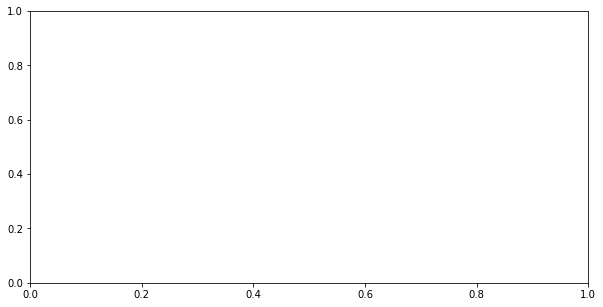

In [57]:
iis = [11,13] #, 14]
dn2=100
#sx=5
#sy=5
for ii in range(len(iis)):    
    col = np.array([200, 200, 245])/255
    
    f, ax =plt.subplots(figsize=(sx, sy))
    dt=0.1
    tplus=1
    tminus=20
    Tmax = 150
    ##A = As[0,:Na1] #np.mean(As[:200,:Na1],axis=0)
    #A = As[iis[ii],Na1-9:Na1]
    #A = np.append([0],A)
    #T_A = Tall_A[-9:-1]
    #T_A = np.append(T_A,[T_A[-1]+2*Tmax])
    Epsp =[]
    for iii in range(dn2):
        A = As[iis[ii]*dn2+iii,0:Na1]
        A = np.append([0],A)
        T_A = Tall_A[0:-1]
        T_A = np.append(T_A,[T_A[-1]+2*Tmax])

        epsp, t = epsp_sim(A, T_A,dt,tplus,tminus,Tmax)
        Epsp = Epsp + [epsp[1,:].reshape([-1,1])]
     
    
    amps3 = As[iis[ii]*dn2+np.arange(dn2),0:Na1][:,-8:-1]
    ism1 = amps3[:,-1]>0.8
    amps3 = amps3[:,:]
    amps3 = amps3*(1 + np.random.normal(size=amps3.shape)*0.15)
    #positions = t[14800] +3.7+25 + int(25)*np.arange(amps3.shape[1])
    
    Epsp = np.concatenate(Epsp, axis=1)
    
    Epsp = Epsp[:,ism1]
    Epsp = (np.random.normal(size=Epsp.shape)*0.1+1)*Epsp
    plt.plot(t[14800:], Epsp[14800:,:],linewidth=1,color=np.array([0, 69, 245])/255) 
    
    fig,ax = plt.subplots(figsize=(sx, sy))
    plt.plot(np.arange(amps3.shape[1])+1,amps3.transpose(),'-o',linewidth=1,color=col)
    plt.boxplot(amps3, widths = 0.7)
    ax.set_ylim([0,1.7])
    
#     pyplot.boxplot(x, notch=None, sym=None, vert=None, whis=None, positions=None, widths=None, 
#                    patch_artist=None, bootstrap=None, usermedians=None, conf_intervals=None, meanline=None, showmeans=None, 
#                    showcaps=None, showbox=None, showfliers=None, boxprops=None, labels=None, flierprops=None, medianprops=None,
#                    meanprops=None, 
#                    capprops=None, whiskerprops=None, manage_ticks=True, autorange=False, zorder=None, *, data=None)
    
    str_syn_type = ge_data_temp.iloc[iis[ii]*dn2,:].loc['cell_type2_pre']+'->'+ge_data_temp.iloc[iis[ii],:].loc['cell_type2_post']
    #plt.title(str(iis[ii])+' '+str_syn_type) 
    
    fig,ax = plt.subplots(figsize=(sx, sy))
    ge_data_temp.iloc[iis[ii]*dn2,:].loc['cell_type2_pre']
    
    plt.plot(np.arange(amps3.shape[1])+1,amps3.transpose(),'-o',linewidth=1,color=col)


    

In [58]:
amps3.shape

NameError: name 'amps3' is not defined

In [59]:
positions.shape

NameError: name 'positions' is not defined

In [60]:
import matplotlib.pyplot as plt 
%matplotlib inline
# transform labels from TM to An:A1
fs = [20 , 10, 40] # Hz
N = 8

Trec = [250, 1000]
Trec=[]
DT0 = 25000
xs  =ge_data.iloc[l_pre_post2:,:].loc[:,stp_aba_names].values
xs  =np.delete(xs, [5,6],axis=1)
As=np.zeros((l_pre_post2,0))
As2=np.zeros((xs.shape[0],0))
Tall_A = np.arange(1)
if do_add_aba_synphys:
    
    for f in fs:
        T = np.arange(N)*1000/f
        Tall_A = np.append(Tall_A, T+DT0+Tall_A[-1])
        
        Asf, ns, ps, dpp0, p0, tF, tD, A = STP_sim(ge_data.iloc[0:l_pre_post2,:],T)
        As = np.concatenate([As,Asf],axis=1)
        
        for ri in range(len(Trec)):
            Asr, nsr, psr, dpp0, p0, tF, tD, A = STP_sim(ge_data.iloc[0:l_pre_post2,:],[Trec[ri]],init_state=[ns[:,-1],ps[:,-1]])
            As = np.concatenate([As,Asr],axis=1)
        Tall_A = np.append(Tall_A, np.array(Trec)+Tall_A[-1])
        

        As2f = np.zeros((xs.shape[0],N+len(Trec)))
        for i2 in range(xs.shape[0]):
            #as2, sts2 = STP_sim2(xs[i2,:],np.arange(8)*50,model_type = 'tm5') # preconditioning series???
            #as2, sts2 = STP_sim2(xs[i2,:], T+DT0, init_state=sts2[-1], model_type='tm5' ) 
            
            as2, sts2 = STP_sim2(xs[i2,:],T,model_type = 'tm5_smr')
            
            As2f[i2,0:N] = as2
            for ri in range(len(Trec)):
                as2r, sts2r = STP_sim2(xs[i2,:], [Trec[ri]], init_state=sts2[-1], model_type='tm5_smr' ) 
                As2f[i2,N+ri] = as2r
                
        As2 = np.concatenate([As2,As2f],axis=1)
            
    
    As2 = As2/As2[:,0].reshape((-1,1))
    As = As/As[:,0].reshape((-1,1))
    Na1 = As.shape[1]
    As = np.concatenate([As,As2],axis=0)
else:
    As, ns, ps, dpp0, p0, tF, tD, A = STP_sim(ge_data,T)
    

sx=12
sy=3
f, ax =plt.subplots(figsize=(sx, sy))
plt.plot(As2[0:1,:].transpose(),'o-',linewidth=4, markersize=12)
plt.ylim([0,1.2])
plt.xticks(fontsize=18)
plt.xticks(ticks=[0,5,10,15,20],fontsize=18)
plt.yticks(ticks=[0.5,1.0,1.5],fontsize=18)
plt.ylabel('An:A1',fontsize=20)
plt.xlabel('Stimulus number',fontsize=20)
#plt.legend(fontsize=20)
#print(set(n_stp_cells.index).difference(set(i2)))


f, ax =plt.subplots(figsize=(sx, sy))
dt=0.1
tplus=1
tminus=10
Tmax = 300
#A = As[0,:Na1] #np.mean(As[:200,:Na1],axis=0)
A = As[0,:Na1]
A = np.append([0],A)
T_A = Tall_A
T_A = np.append(T_A,[T_A[-1]+Tmax])

epsp, t = epsp_sim(A, T_A,dt,tplus,tminus,Tmax)
plt.plot(t, epsp[1,:].T,linewidth=4)

NameError: name 'l_pre_post2' is not defined

In [180]:
def plot_fig9b(i0,ge_data, tplus=5, tminus=50, Nbootstraps=200, Dn=200):
    dt=0.1
    #tplus=5
    #tminus=50
    Tmax = 300
    DT = 200/6

    #i0=23 #42 #[18,23,42]
    ii = i0*Nbootstraps + np.arange(0,Nbootstraps,Dn)
    T_A = np.array([0]+(100+np.arange(9)*200/6).tolist()+[100+200/6*8+1000])
    As, ns, ps, dpp0, p0, tF, tD, A = STP_sim(ge_data.iloc[ii,:],T_A)


    A = np.mean(As,axis=0) #As[0,:Na1]#np.mean(As[:100,:Na1],axis=0)
    A = np.append([0],A)
    #T_A = Tall_A
    T_A = np.append(T_A,[T_A[-1]+400])
    
    

    epsp, t = epsp_sim(A, T_A,dt,tplus,tminus,Tmax)
    #plt.plot(t, epsp[1,:].T)
    
    return epsp[1,:].T, t, As

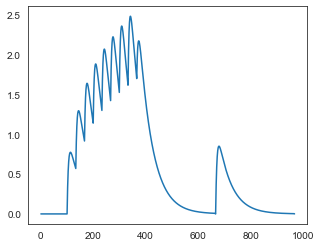

In [181]:
f, ax =plt.subplots(figsize=(sx, sy))
dt=0.1
tplus=5
tminus=50
Tmax = 300

DT = 200/6

T_A = np.array([0]+(100+np.arange(9)*200/6).tolist()+[100+200/6*8+1000])

i0=23 #42 #[18,23,42]
ii = i0*200 + np.arange(200)
A = np.mean(As[ii,:Na1],axis=0) #As[0,:Na1]#np.mean(As[:100,:Na1],axis=0)
A = np.append([0],A)
#T_A = Tall_A
T_A = np.append(T_A,[T_A[-1]+400])

epsp, t = epsp_sim(A, T_A,dt,tplus,tminus,Tmax)
plt.plot(t, epsp[1,:].T)

### Classify STP for cortex : 3 types by D/F ratio

0  PV_L4->PC_L4  F/D  : ['0  PV_L4->PC_L4', 0.78, 0.22, 0.0, True, False, False, 0.007543486035438326, 0.002, array([0.002     , 0.26694421, 0.002     , 0.0404054 , 0.00848606,
       0.002     , 0.00901483, 0.00284819, 1.        , 0.00919855,
       0.00781301, 0.00217601, 1.        , 0.00443841, 1.        ,
       0.00426758, 0.002     , 1.        , 1.        , 0.02372601,
       0.002     , 0.13140102, 0.01589715, 0.01020076, 0.00562516,
       1.        , 0.00275577, 0.09568914, 1.21754966, 1.        ,
       1.        , 0.00727396, 0.002     , 0.09187596, 1.        ,
       0.002     , 0.00539417, 0.002     , 0.002     , 0.01594631,
       0.002     , 0.00219389, 0.32391282, 1.85515664, 0.00305491,
       0.002     , 0.002     , 0.00228954, 0.002     , 0.002     ,
       0.002     , 0.26694421, 0.002     , 0.0404054 , 0.00848606,
       0.002     , 0.00901483, 0.00284819, 1.        , 0.00919855,
       0.00781301, 0.00217601, 1.        , 0.00443841, 1.        ,
       0.00426758, 

/Applications/anaconda2/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Applications/anaconda2/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


10  PC_['L4']->vip_['L4']  F/D  : ["10  PC_['L4']->vip_['L4']", 0.22, 0.4, 0.38, True, False, False, 1.5894208219055934, 0.28450253668165015, array([2.84502537e-01, 1.00000000e+00, 1.92068262e+00, 3.96949858e+00,
       5.29010787e-02, 1.70609954e+00, 1.10951925e+00, 1.00000000e+00,
       2.85522746e+00, 1.92085052e-01, 1.74386295e+00, 3.96710790e+00,
       1.00000000e+00, 2.04672342e+00, 1.00000000e+00, 1.69654563e+00,
       1.00000000e+00, 1.00000000e+00, 2.13468066e+00, 7.73292096e-02,
       1.83559603e+00, 1.07772624e+00, 8.50611643e-02, 3.21609302e+00,
       2.68350614e-01, 1.91355445e+00, 6.95621319e-02, 9.39616974e-01,
       3.31972191e+00, 2.79827825e+00, 2.90597083e+00, 3.84041422e+00,
       2.71961597e+00, 4.53477339e+01, 3.09870770e+00, 4.03014347e-01,
       4.05067522e+00, 1.00000000e+00, 2.63693895e+00, 2.08898296e+00,
       1.56262135e-02, 5.70751662e-01, 3.25980247e-02, 4.98820357e+00,
       1.95172775e+00, 1.00000000e+00, 4.98440681e-02, 2.35510922e+00,
      

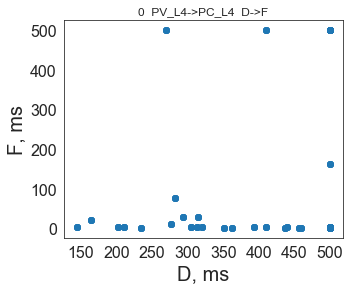

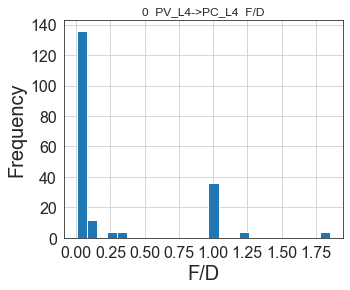

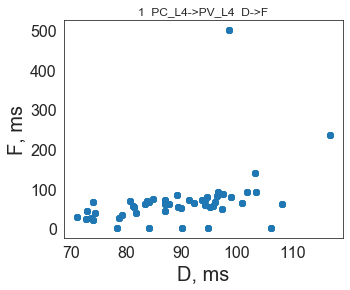

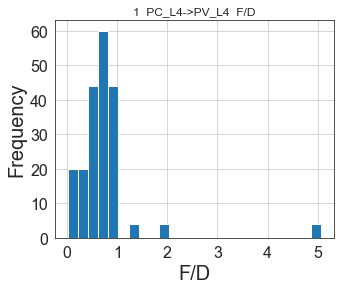

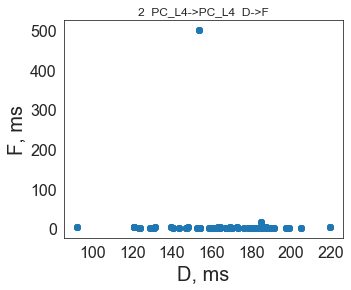

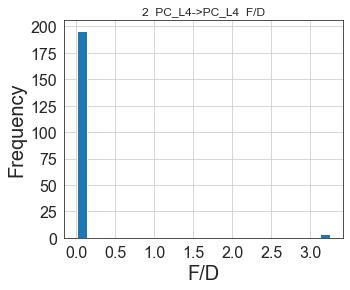

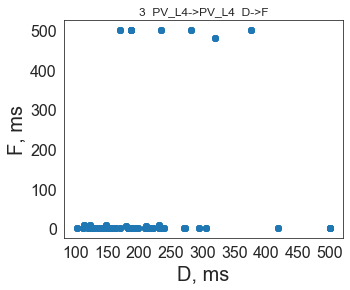

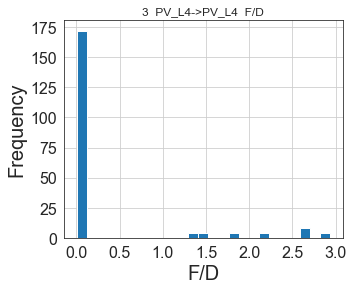

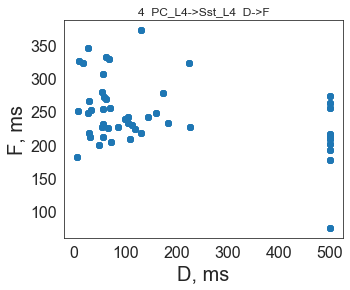

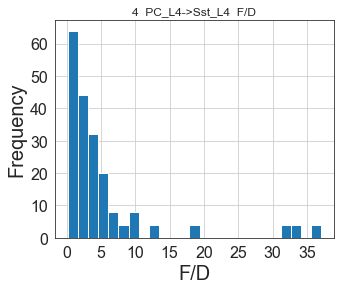

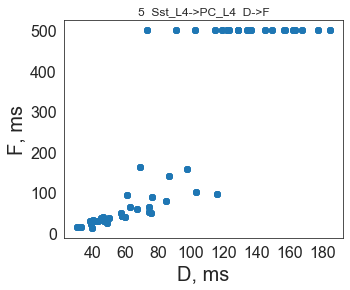

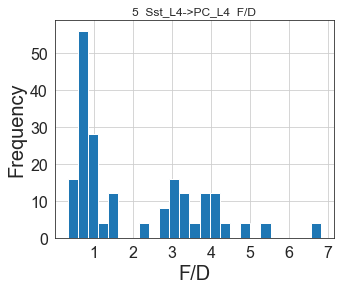

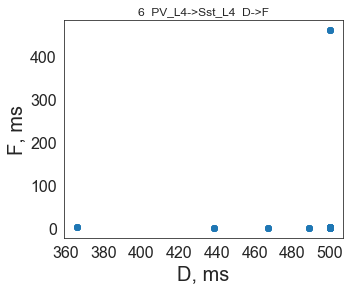

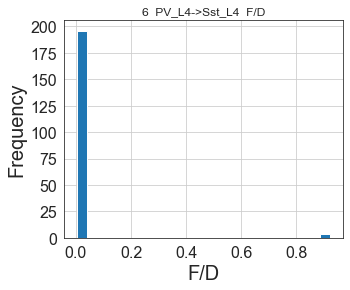

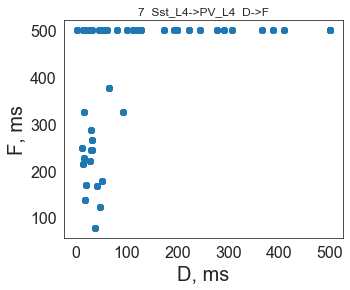

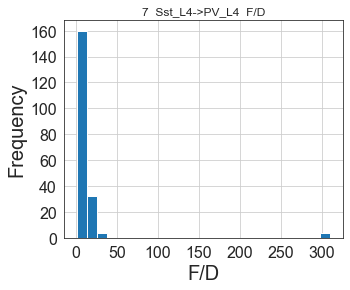

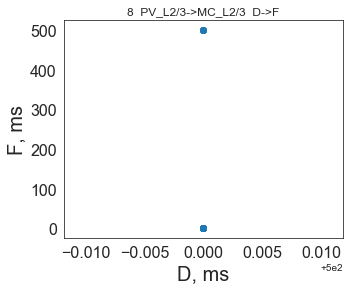

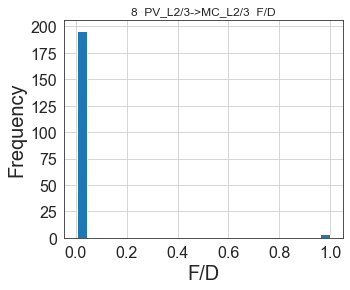

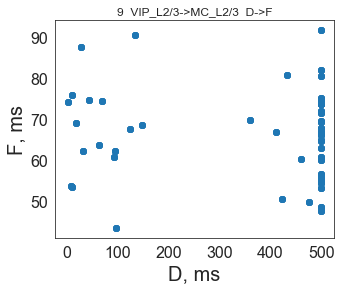

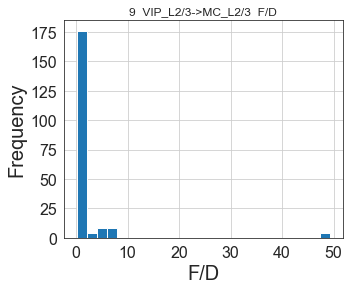

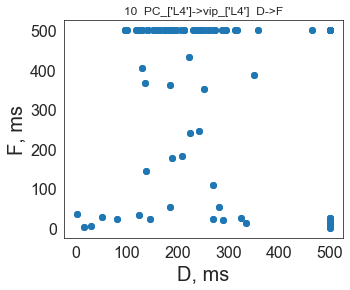

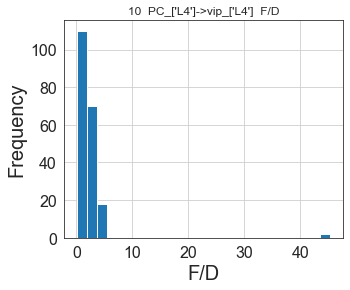

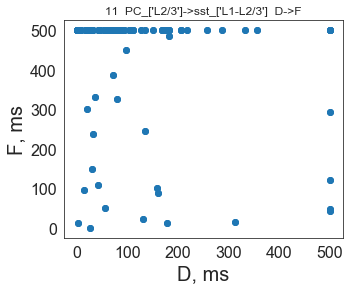

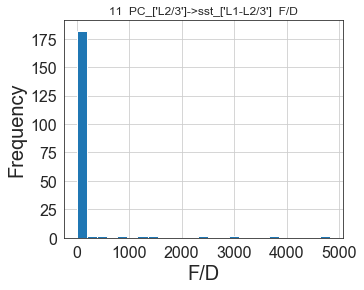

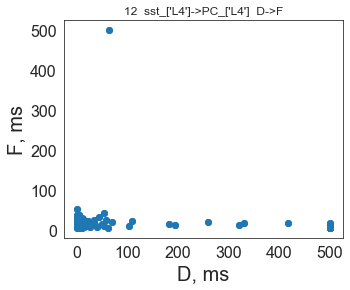

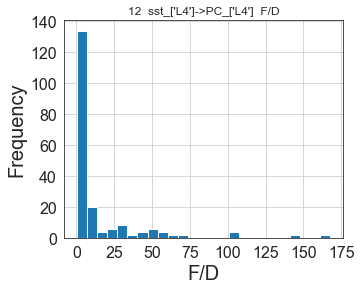

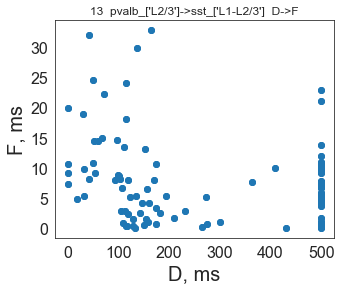

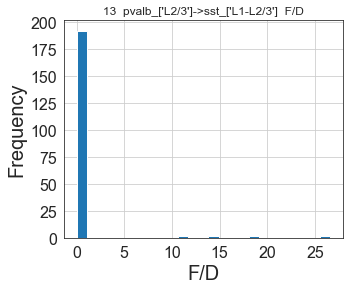

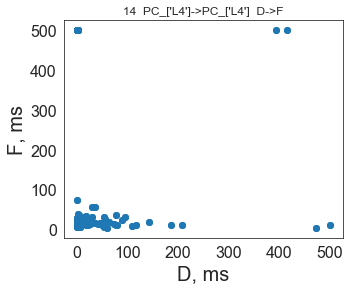

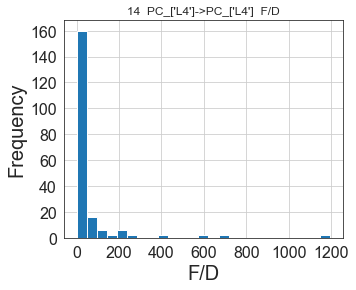

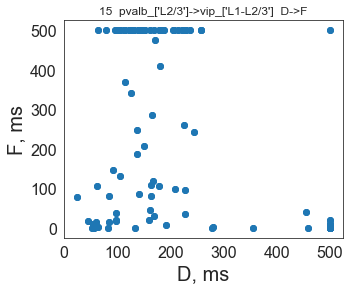

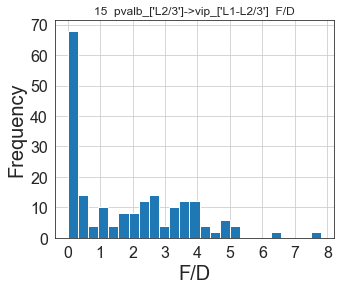

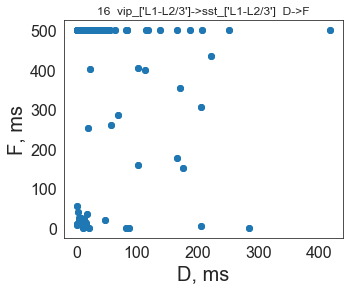

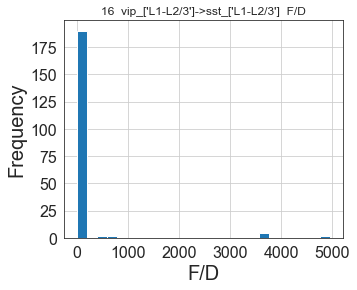

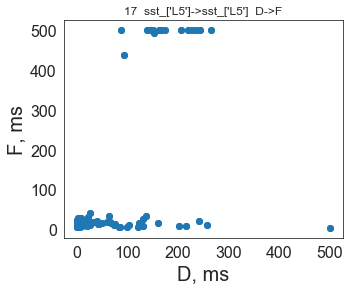

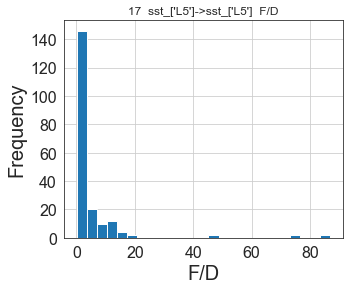

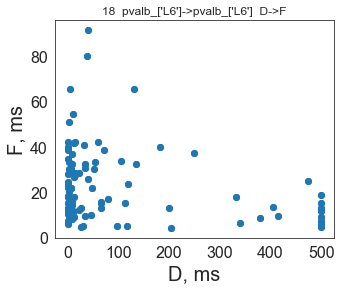

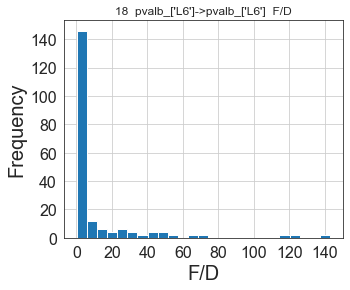

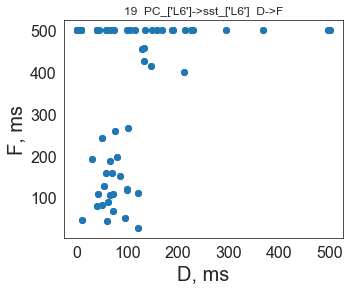

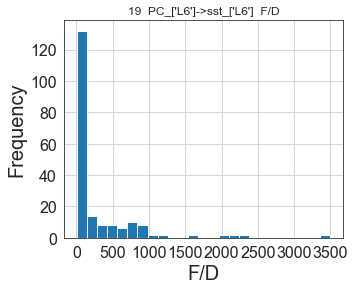

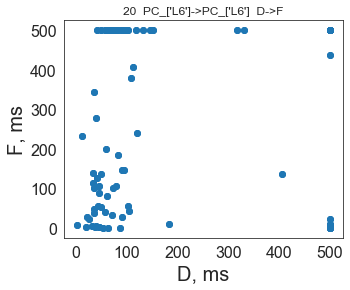

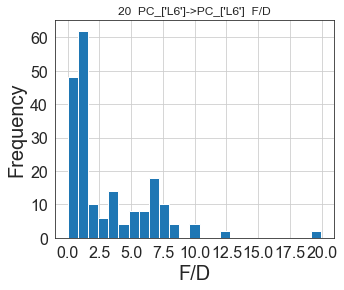

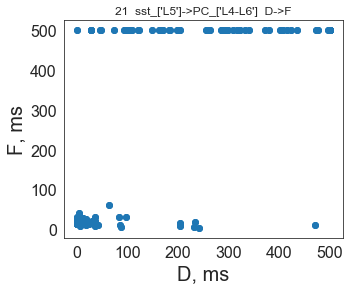

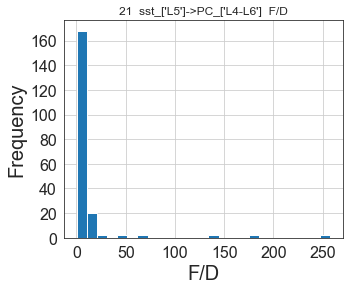

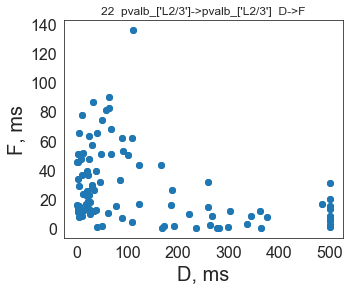

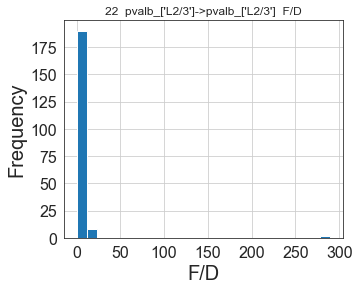

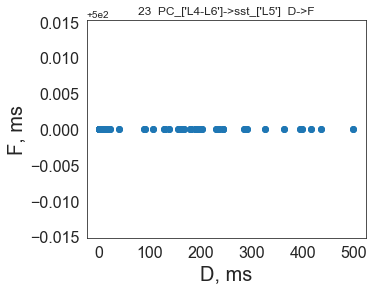

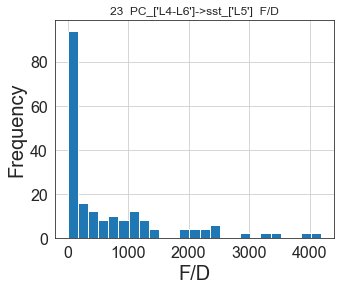

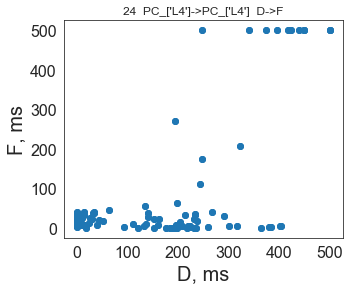

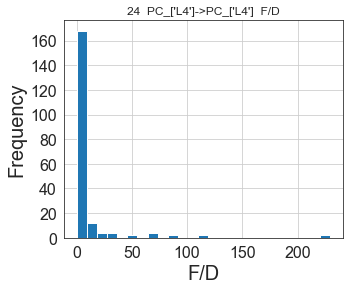

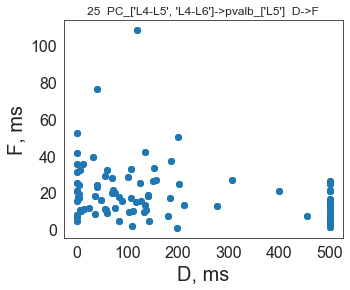

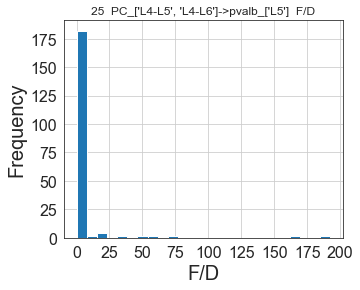

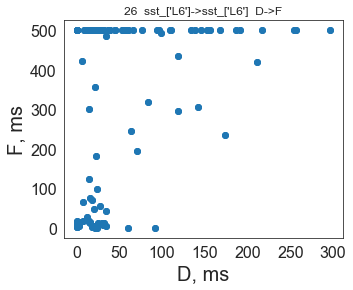

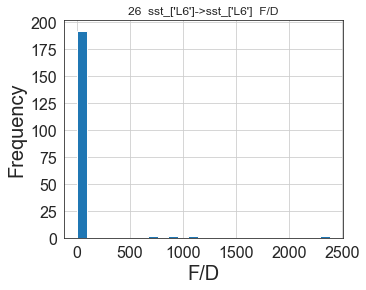

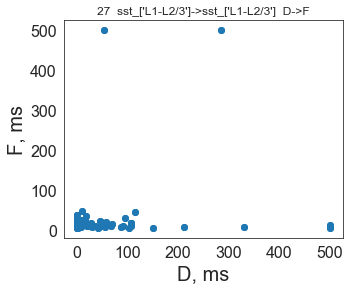

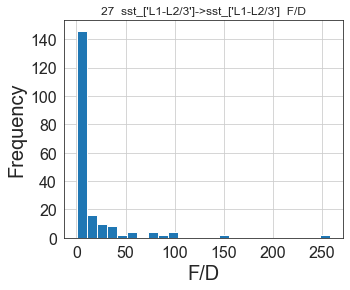

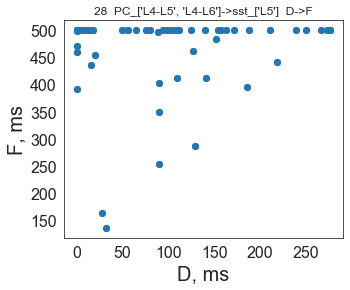

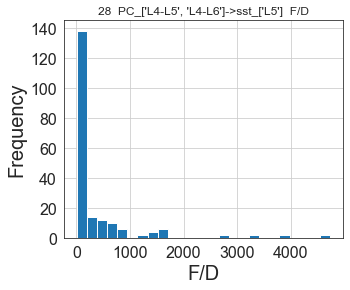

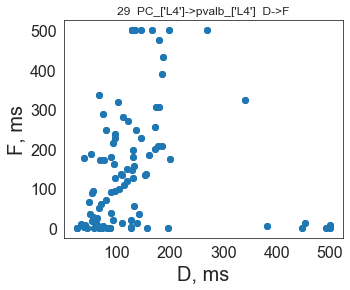

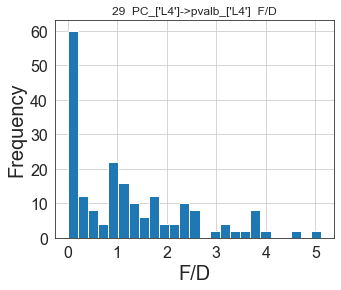

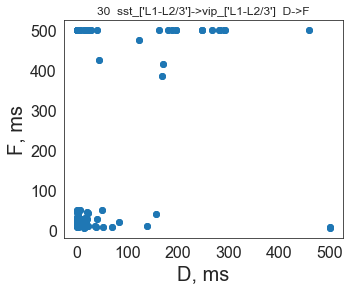

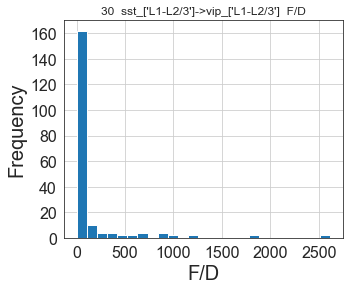

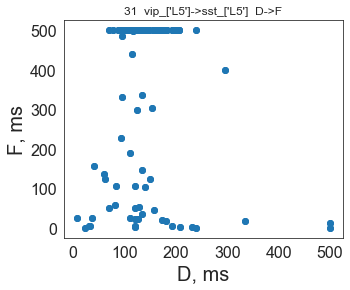

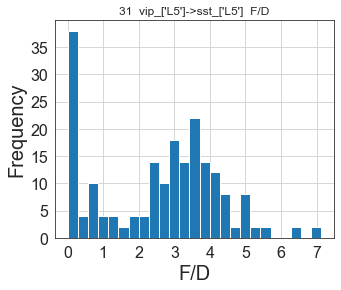

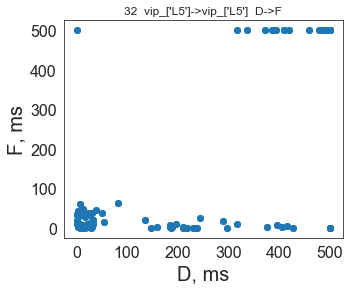

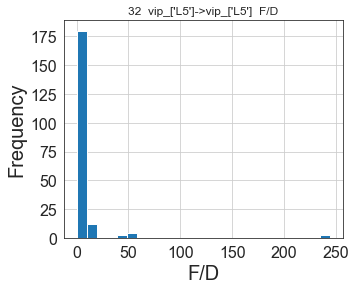

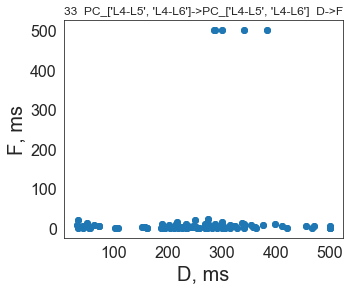

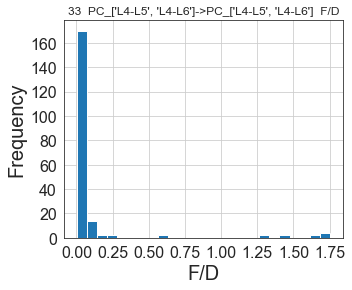

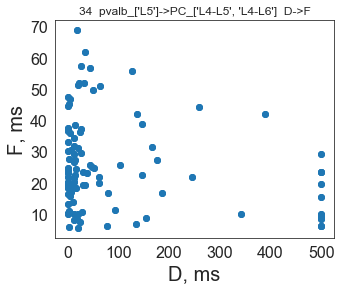

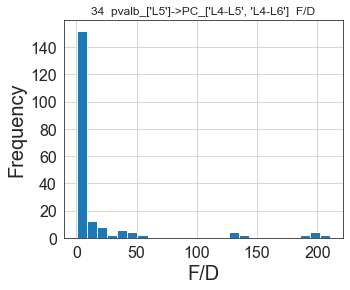

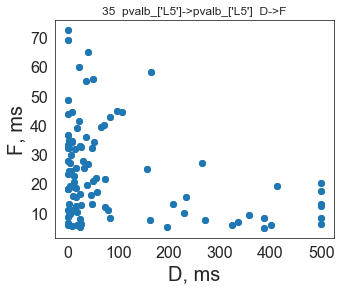

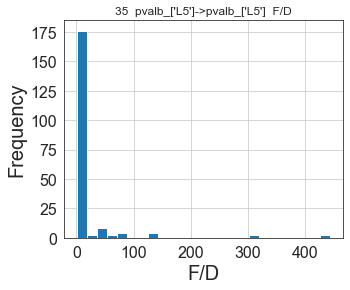

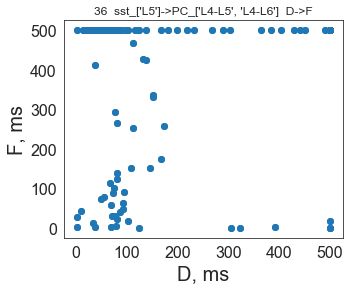

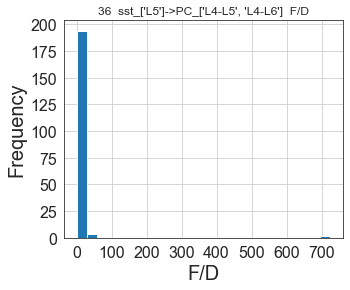

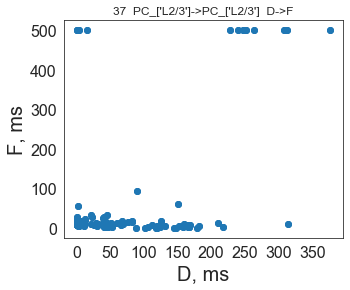

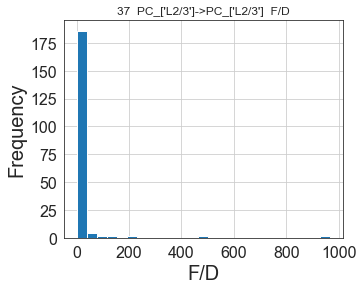

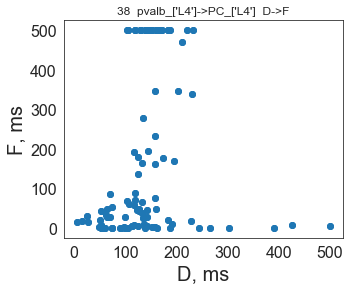

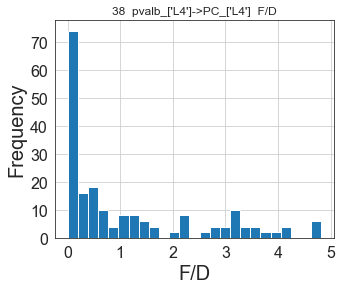

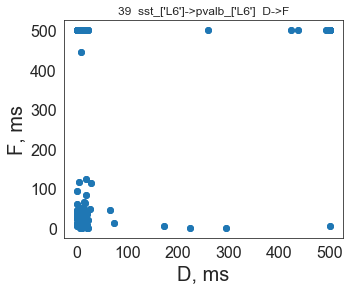

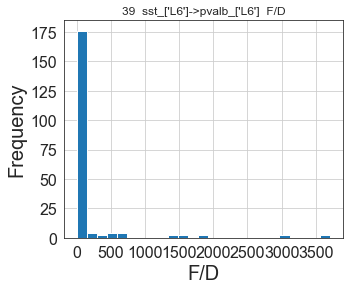

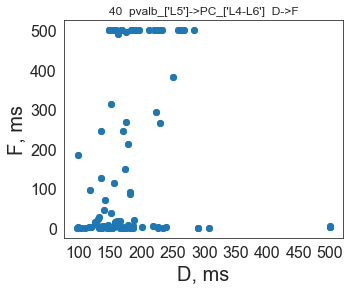

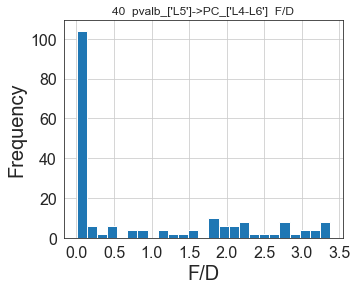

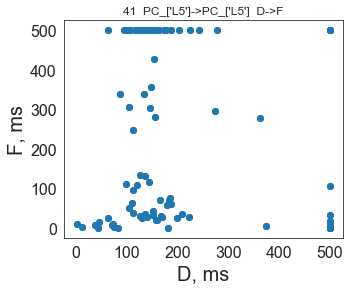

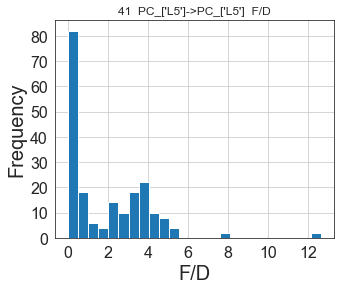

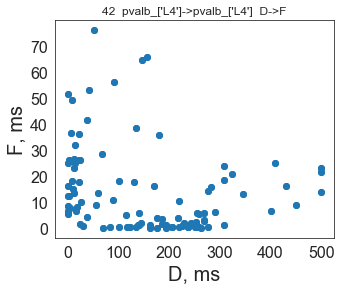

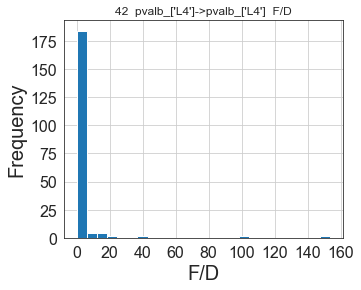

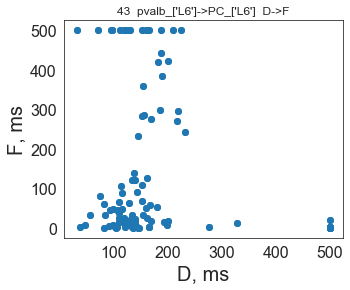

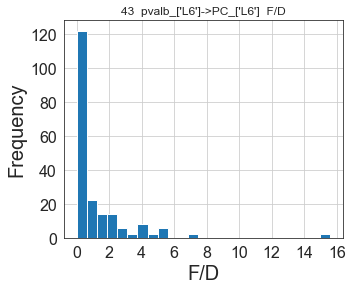

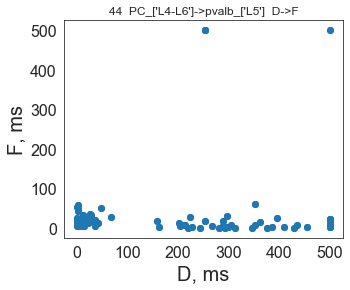

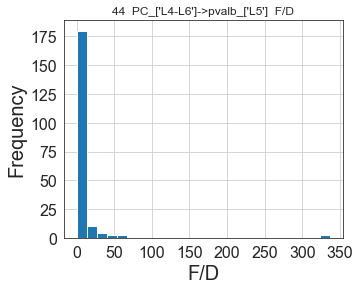

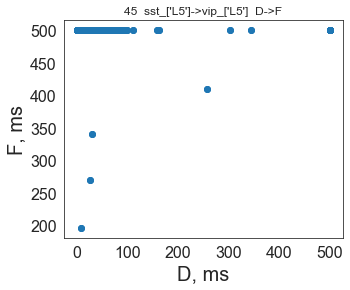

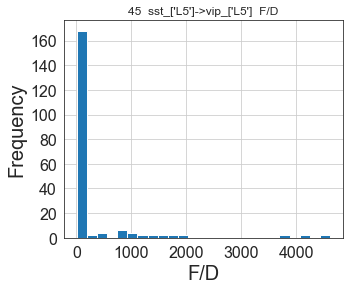

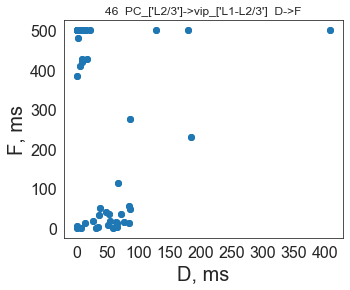

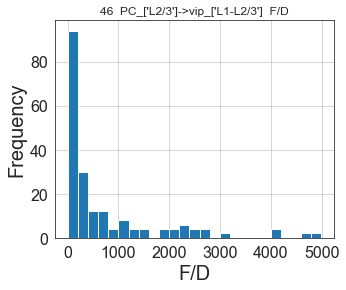

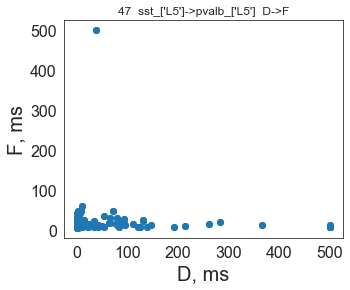

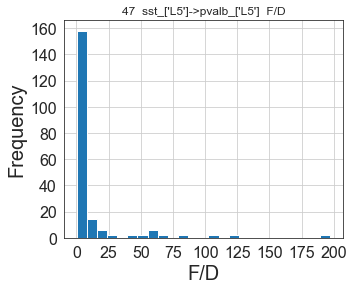

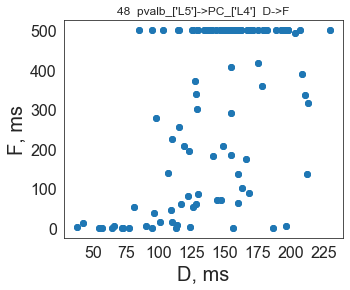

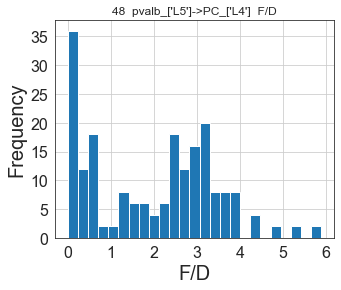

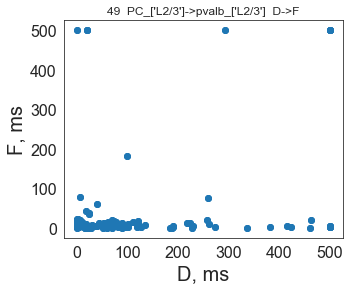

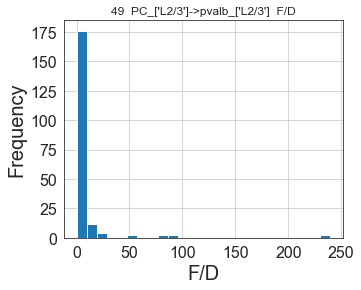

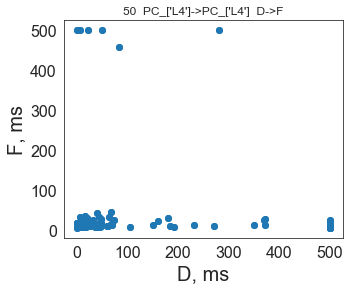

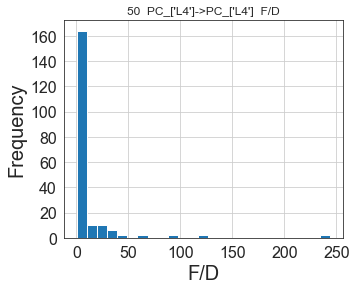

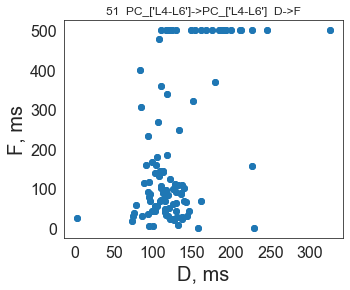

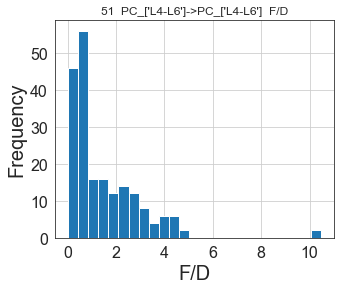

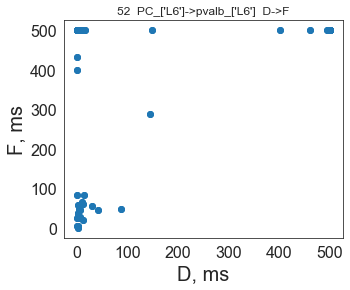

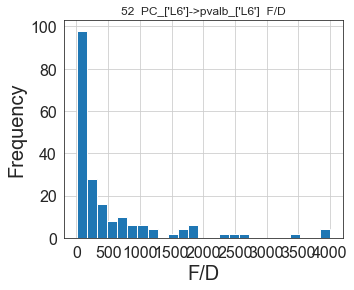

In [182]:
%matplotlib inline


#
#do_medians, do_log should be off!!!
# Nsamples = 200 !!!


## some distributions
#stp_columns

# f, ax =plt.subplots(figsize=(16, 7))
# plt.plot(ge_data.iloc[3600:3800,:].loc[:,stp_columns].transpose(),'o-')
# plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
#          rotation_mode="anchor")

#f, ax =plt.subplots(figsize=(16, 7))
stp_columns2=np.array(stp_columns)
annot_columns2 =np.array(annot_columns)
sx=5
sy=4
i0=0
skip_this=1

Stp_type_p = []

for i0 in range(0,53):#[42]: # [18,23,42] #range(0,53):
    str_syntype = ge_data.loc[i0*200,annot_columns2[[0,2,1,3]]].astype(str).str.cat(others=['_','->','_','']).str.cat()

    #print(ge_data.loc[i0*200,annot_columns[:-3]])

    ii = i0*200 + np.arange(200)
    
    f, ax =plt.subplots(figsize=(sx, sy))
    dat=ge_data.iloc[ii,:].loc[:,'tD'].map(float)
    #dat=dat.loc[dat.loc[:]<800]
    dat.loc[dat.loc[:]>500]=500
    dat2=ge_data.iloc[ii,:].loc[:,'tF'].map(float)
    #dat2=dat2.loc[dat2.loc[:]<5500]
    dat2.loc[dat2.loc[:]>500]=500
    plt.scatter(dat,dat2)
    
    #dat.hist(bins=25)
    plt.title(str(i0)+ '  '+str_syntype + '  ' +'D->F')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('D, ms',fontsize=20)
    plt.ylabel('F, ms',fontsize=20)

    f, ax =plt.subplots(figsize=(sx, sy))
    #ge_data.iloc[ii,:].loc[:,'tF'].map(float).hist(bins=25)
    
    dat3 = dat2/dat
    dat3.hist(bins=25)
    plt.title(str(i0)+ '  '+str_syntype + '  ' +'F/D')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('F/D',fontsize=20)
    plt.ylabel('Frequency',fontsize=20)
    nsam = dat3.shape[0]
    #print(str(i0)+ '  '+str_syntype + '  ' +'F/D  :','<0.2 - ',(dat3<0.2).sum()/nsam,
    #      '; >0.2, <2 - ',((dat3>0.2)&(dat3<2)).sum()/nsam, '; >2 - ',(dat3>2).sum()/nsam  )
    stp_type_p = [str(i0)+ '  '+str_syntype,
                  (dat3<0.4).sum()/nsam, ((dat3>0.4)&(dat3<2)).sum()/nsam, (dat3>2).sum()/nsam ,
                  (dat3.iloc[0]<0.4), (dat3.iloc[0]>0.4)&(dat3.iloc[0]<2), (dat3.iloc[0]>2),
                  np.median(dat3),dat3.iloc[0], dat3.values]
    Stp_type_p = Stp_type_p + [stp_type_p]
    
    
    
    print(str(i0)+ '  '+str_syntype + '  ' +'F/D  :',stp_type_p   )

### STP classes in hippocampus based on D/F ratio

0  PV_DG->PV_DG  F/D  : ['0  PV_DG->PV_DG', 0.99, 0.01, 0.0, True, False, False, 0.002, 0.002, array([0.002, 1.   , 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 1.   , 0.002, 0.002, 0.002, 0.002, 0.002, 0.002,
       0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.

/Applications/anaconda2/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Applications/anaconda2/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


10  PV_CA3->PV_CA3  F/D  : ['10  PV_CA3->PV_CA3', 1.0, 0.0, 0.0, True, False, False, 0.002338691206203785, 0.00232012891025952, array([0.00232013, 0.00328486, 0.06893848, 0.00209303, 0.00217417,
       0.00254439, 0.00874349, 0.00238411, 0.002     , 0.002     ,
       0.00303916, 0.00321911, 0.00338259, 0.002     , 0.07071844,
       0.00213457, 0.002     , 0.00201448, 0.00284173, 0.00220909,
       0.002     , 0.002     , 0.00267995, 0.00278278, 0.00279225,
       0.002     , 0.00262514, 0.00349352, 0.00304391, 0.00237961,
       0.002     , 0.002     , 0.00287856, 0.00230574, 0.00222829,
       0.0022309 , 0.0024071 , 0.00227472, 0.0025819 , 0.00228693,
       0.002     , 0.00269592, 0.00254459, 0.01006271, 0.002     ,
       0.00222496, 0.00220273, 0.0029406 , 0.00313634, 0.01159694,
       0.00319647, 0.0031975 , 0.00247102, 0.002     , 0.0022559 ,
       0.00214095, 0.002     , 0.0031175 , 0.002     , 0.00253619,
       0.00282678, 0.002     , 0.00266254, 0.002     , 0.00228214,
 

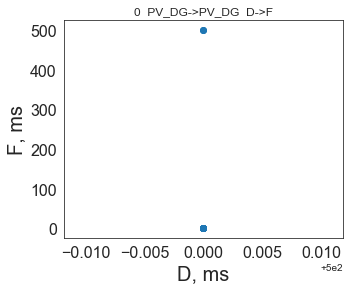

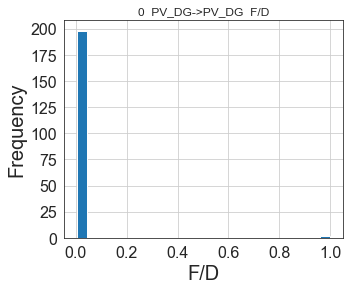

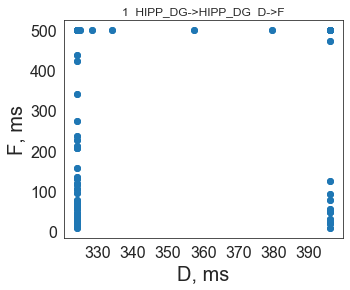

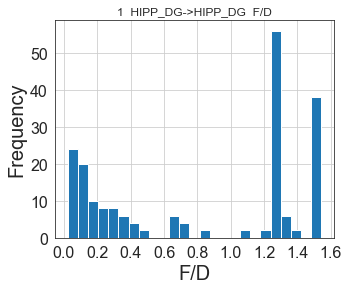

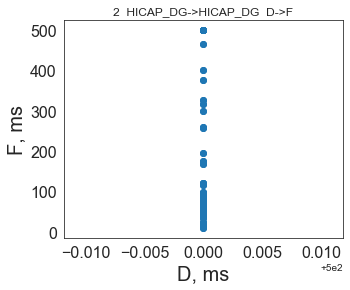

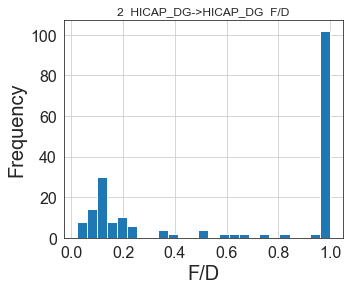

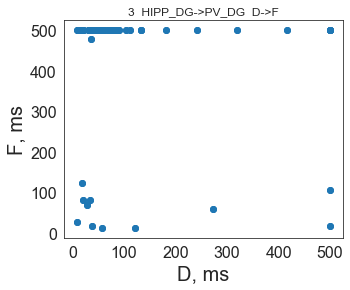

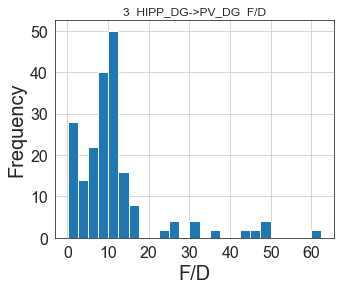

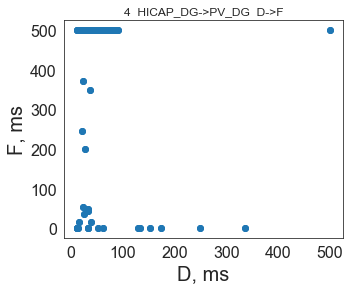

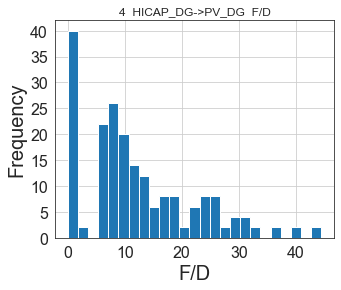

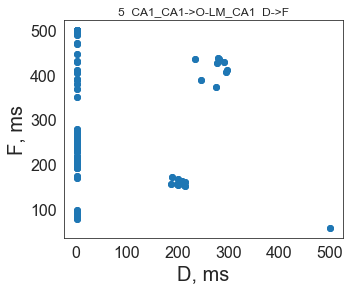

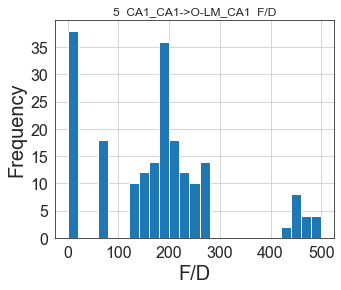

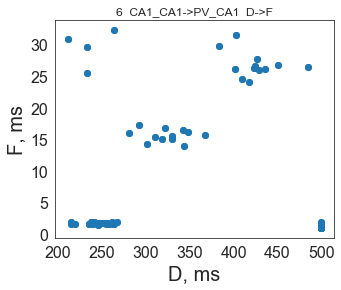

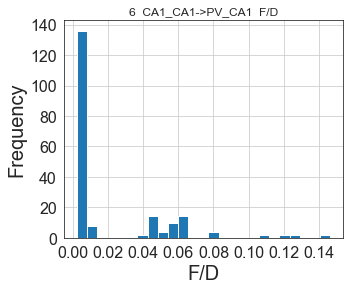

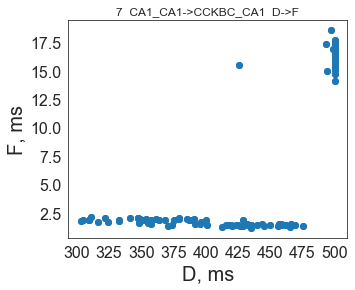

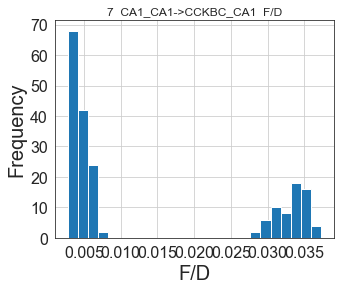

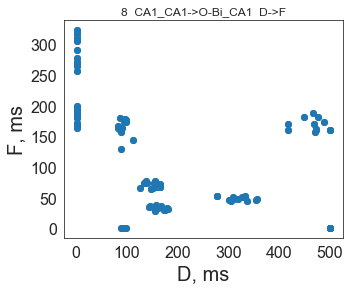

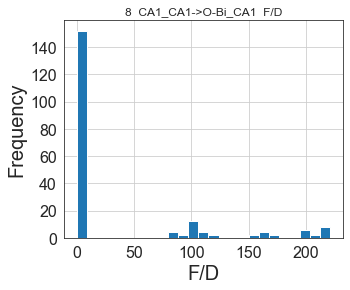

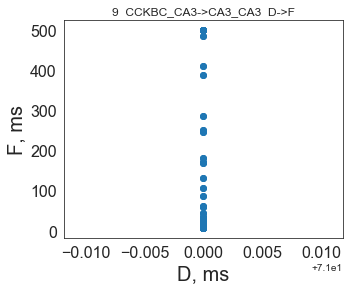

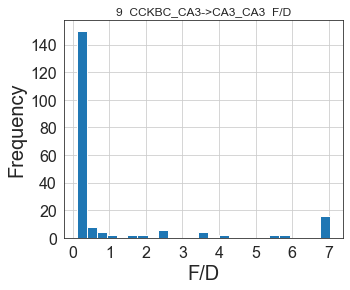

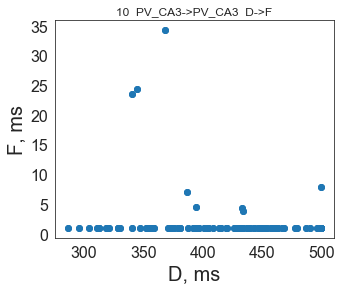

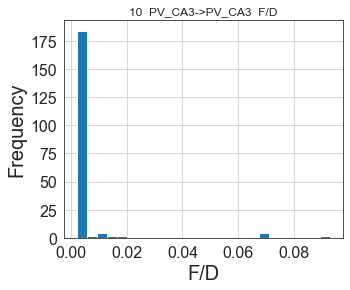

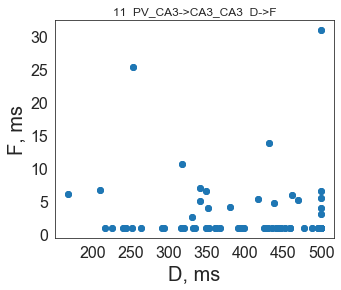

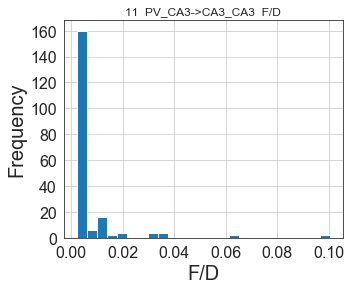

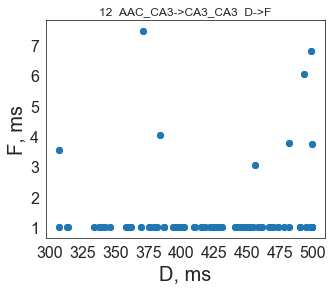

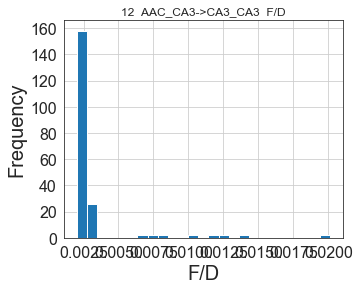

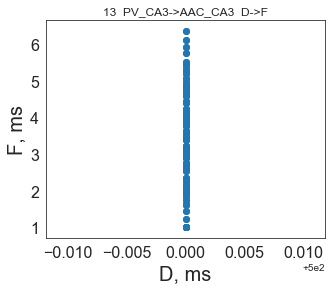

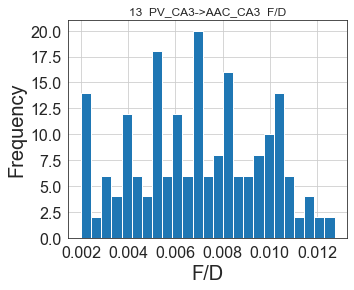

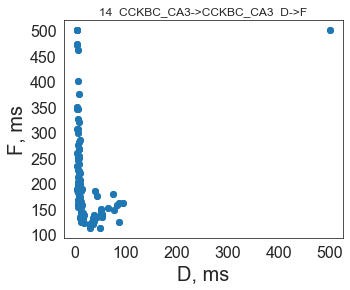

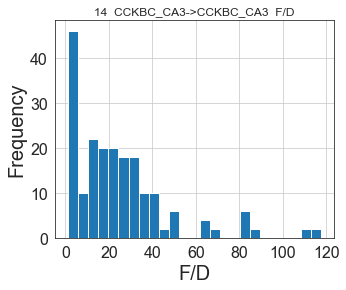

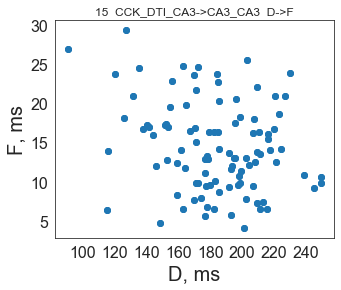

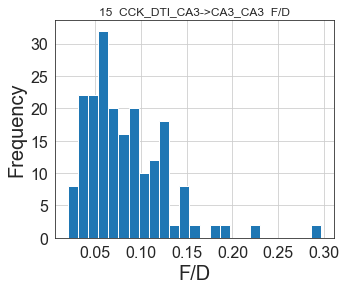

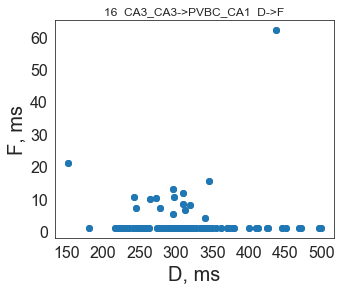

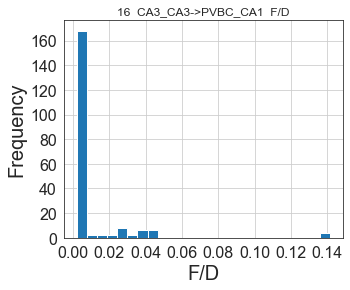

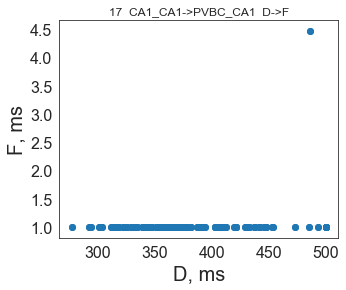

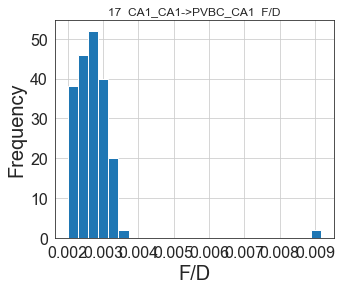

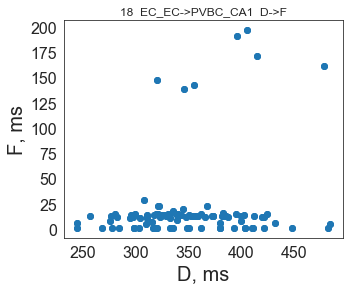

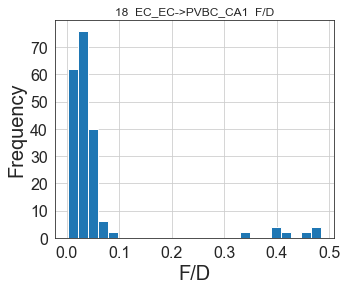

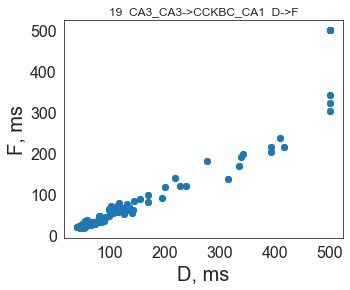

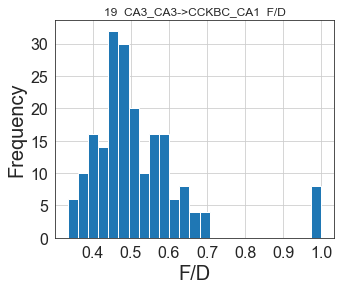

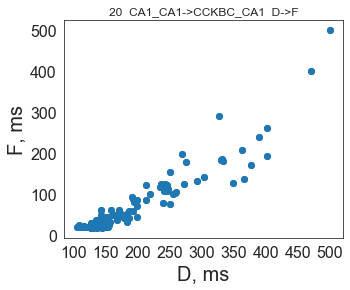

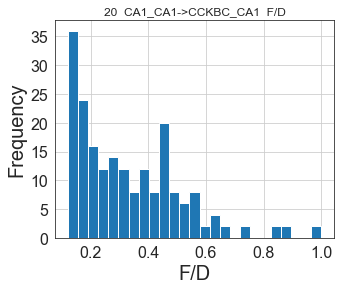

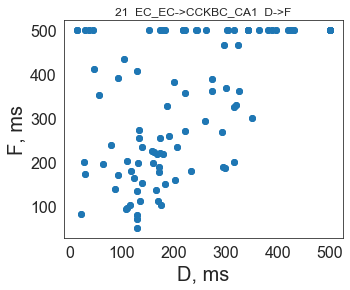

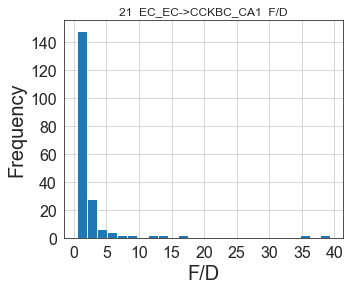

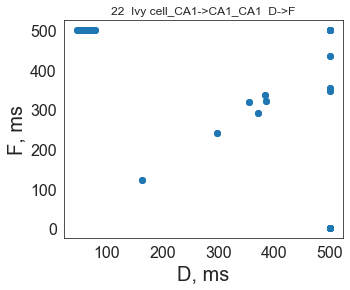

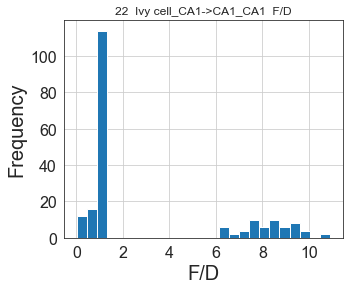

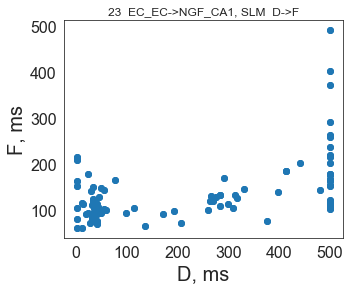

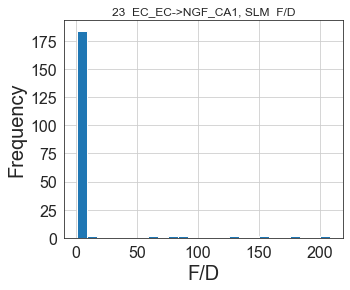

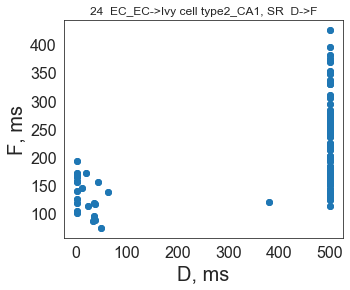

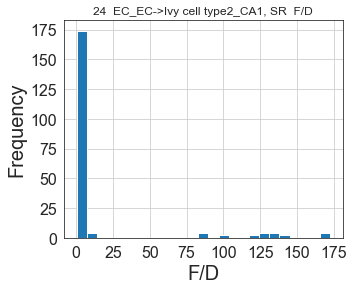

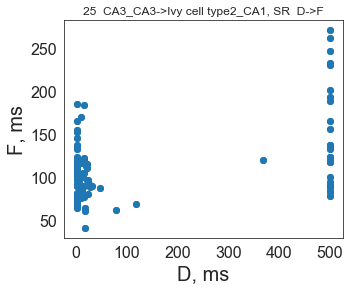

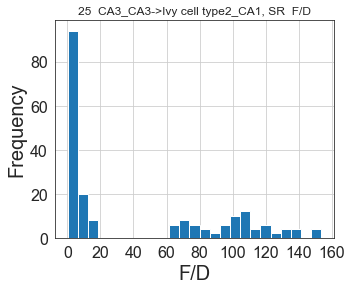

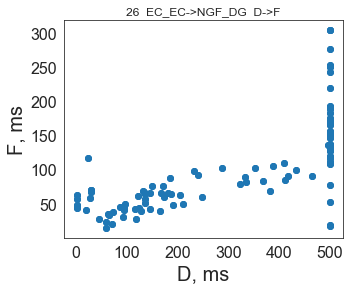

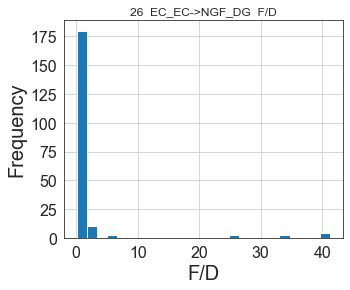

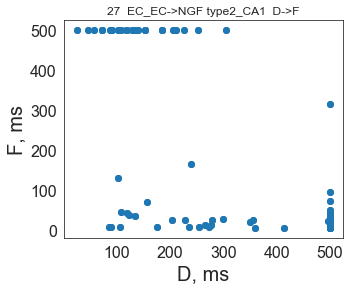

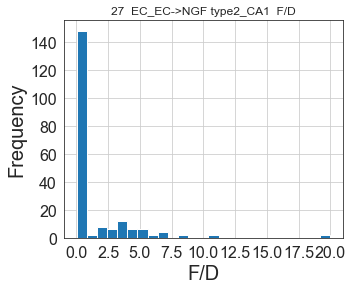

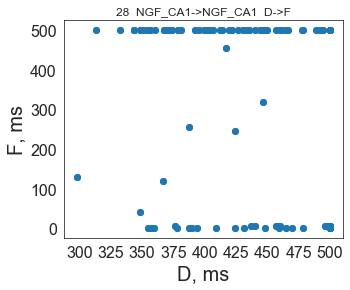

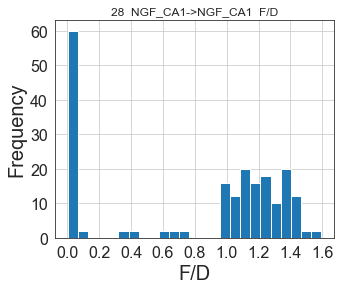

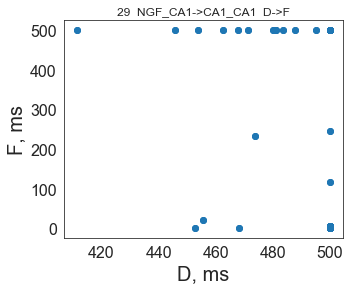

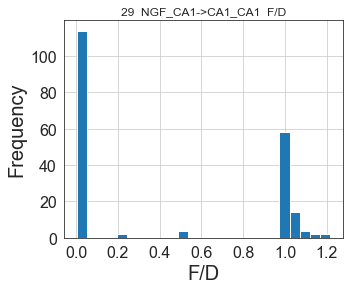

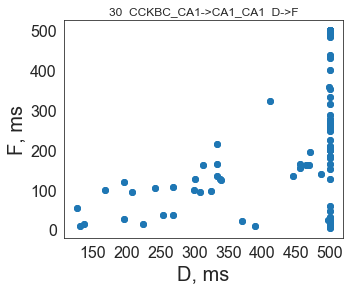

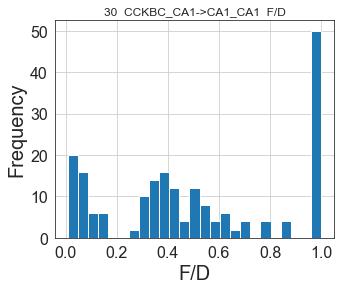

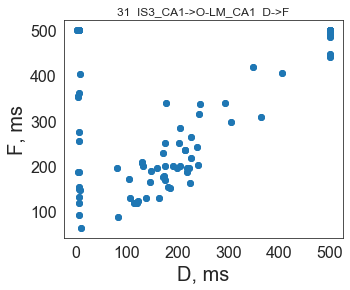

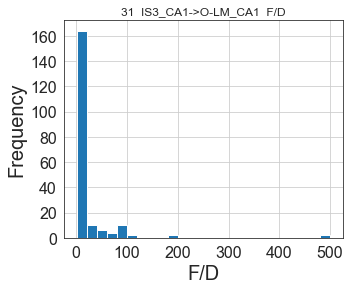

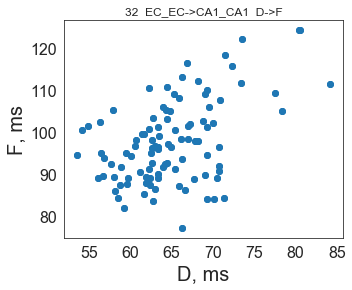

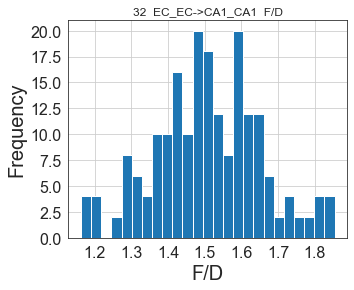

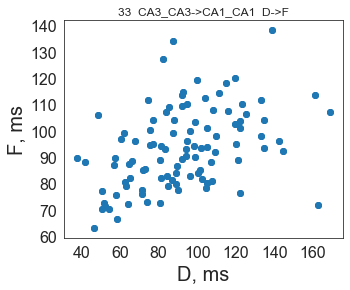

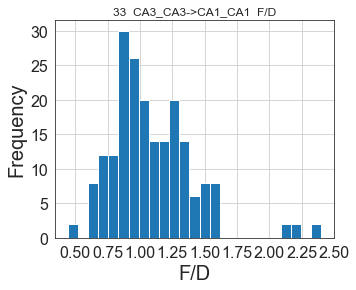

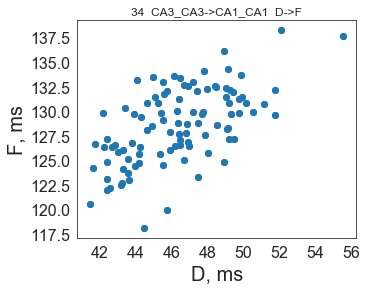

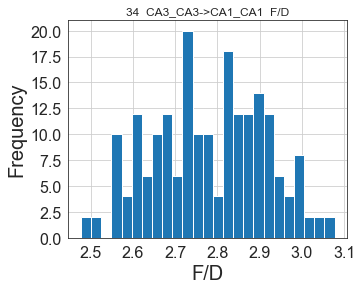

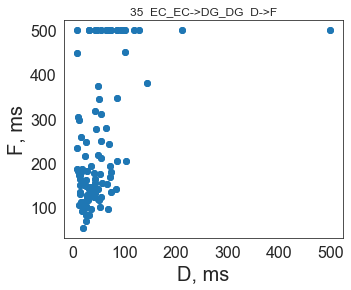

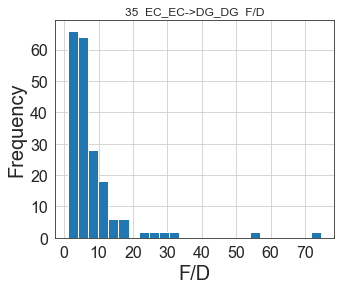

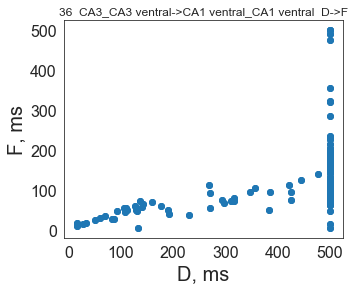

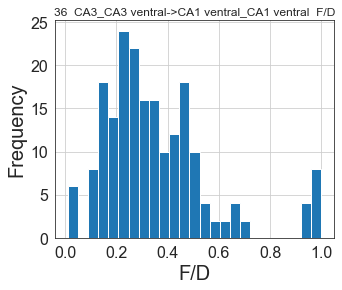

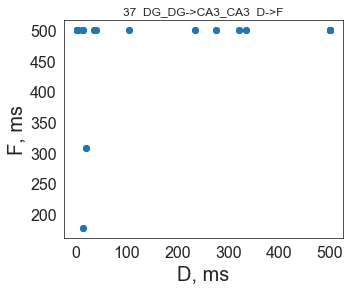

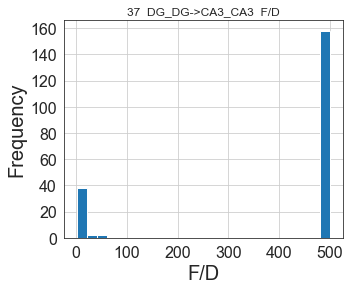

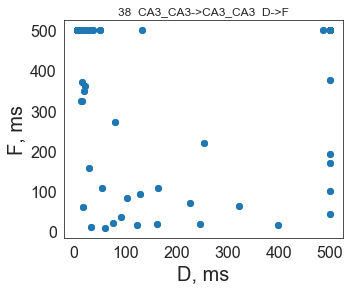

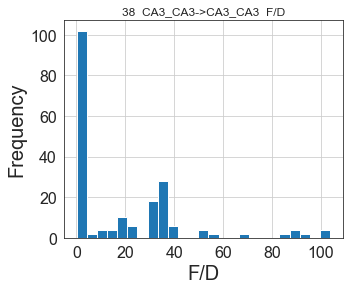

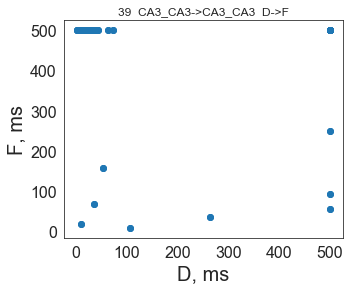

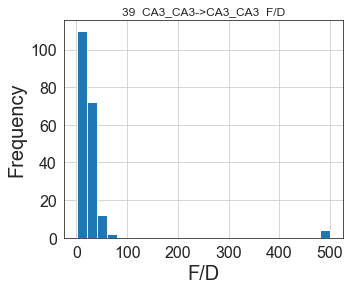

In [183]:
%matplotlib inline


#
#do_medians, do_log should be off!!!
# Nsamples = 200 !!!


## some distributions
#stp_columns

# f, ax =plt.subplots(figsize=(16, 7))
# plt.plot(ge_data.iloc[3600:3800,:].loc[:,stp_columns].transpose(),'o-')
# plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
#          rotation_mode="anchor")

#f, ax =plt.subplots(figsize=(16, 7))
stp_columns2=np.array(stp_columns)
annot_columns2 =np.array(annot_columns)
sx=5
sy=4
i0=0
skip_this=1

Stp_type_p_h = []

for i0 in range(0,40):#[42]: # [18,23,42] #range(0,53):
    str_syntype = ge_data_h.loc[i0*200,annot_columns2[[0,2,1,3]]].astype(str).str.cat(others=['_','->','_','']).str.cat()

    #print(ge_data.loc[i0*200,annot_columns[:-3]])

    ii = i0*200 + np.arange(200)
    
    f, ax =plt.subplots(figsize=(sx, sy))
    dat=ge_data_h.iloc[ii,:].loc[:,'tD'].map(float)
    #dat=dat.loc[dat.loc[:]<800]
    dat.loc[dat.loc[:]>500]=500
    dat2=ge_data_h.iloc[ii,:].loc[:,'tF'].map(float)
    #dat2=dat2.loc[dat2.loc[:]<5500]
    dat2.loc[dat2.loc[:]>500]=500
    plt.scatter(dat,dat2)
    
    #dat.hist(bins=25)
    plt.title(str(i0)+ '  '+str_syntype + '  ' +'D->F')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('D, ms',fontsize=20)
    plt.ylabel('F, ms',fontsize=20)

    f, ax =plt.subplots(figsize=(sx, sy))
    #ge_data.iloc[ii,:].loc[:,'tF'].map(float).hist(bins=25)
    
    dat3 = dat2/dat
    dat3.hist(bins=25)
    plt.title(str(i0)+ '  '+str_syntype + '  ' +'F/D')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('F/D',fontsize=20)
    plt.ylabel('Frequency',fontsize=20)
    nsam = dat3.shape[0]
    #print(str(i0)+ '  '+str_syntype + '  ' +'F/D  :','<0.2 - ',(dat3<0.2).sum()/nsam,
    #      '; >0.2, <2 - ',((dat3>0.2)&(dat3<2)).sum()/nsam, '; >2 - ',(dat3>2).sum()/nsam  )
    #stp_type_p = [str(i0)+ '  '+str_syntype, (dat3<0.4).sum()/nsam, ((dat3>0.4)&(dat3<2)).sum()/nsam, (dat3>2).sum()/nsam, np.median(dat3), dat3.values ]
    
    stp_type_p = [str(i0)+ '  '+str_syntype,
                  (dat3<0.4).sum()/nsam, ((dat3>0.4)&(dat3<2)).sum()/nsam, (dat3>2).sum()/nsam ,
                  (dat3.iloc[0]<0.4), (dat3.iloc[0]>0.4)&(dat3.iloc[0]<2), (dat3.iloc[0]>2),
                  np.median(dat3),dat3.iloc[0], dat3.values]
    Stp_type_p_h = Stp_type_p_h + [stp_type_p]
    
    print(str(i0)+ '  '+str_syntype + '  ' +'F/D  :',stp_type_p   )

In [184]:
df_Stp_type_p = pd.DataFrame(Stp_type_p + Stp_type_p_h, columns=['name','type_2','type_3','type_1',
                                                                 'dtype_2','dtype_3','dtype_1','median','F_D_0','F_D'])
df_Stp_type_p.head()

,name,type_2,type_3,type_1,dtype_2,dtype_3,dtype_1,median,F_D_0,F_D
0,0 PV_L4->PC_L4,0.78,0.22,0.00,True,False,False,0.007543,0.002000,"[0.002, 0.26694420706560107, 0.002, 0.04040539..."
1,1 PC_L4->PV_L4,0.18,0.78,0.04,False,True,False,0.694640,0.828541,"[0.8285407801052448, 0.01111265844781613, 0.00..."
2,2 PC_L4->PC_L4,0.98,0.00,0.02,True,False,False,0.006393,0.006297,"[0.006296872254833685, 0.01696463462043757, 0...."
3,3 PV_L4->PV_L4,0.86,0.06,0.08,True,False,False,0.008581,0.006613,"[0.006613265332229203, 0.003096956158456047, 0..."
4,4 PC_L4->Sst_L4,0.06,0.34,0.60,True,False,False,2.728720,0.150188,"[0.15018805784804642, 37.08026070798316, 1.439..."


In [185]:
df_Stp_type_p.to_excel('stp types probability cortex and hippocampus.xlsx')

### Plot EPSPs for different synaptic types (aka fig9b)

In [186]:
# simulate epsps for fig9a
stp_columns2=np.array(stp_columns)
annot_columns2 =np.array(annot_columns)
sx=5
sy=4
i0=0
skip_this=1

#Stp_type_p = []
EPSP=[]
Ams=[]
for i0 in range(0,53):#[42]: # [18,23,42] #range(0,53):
    str_syntype = ge_data.loc[i0*200,annot_columns2[[0,2,1,3]]].astype(str).str.cat(others=['_','->','_','']).str.cat()

    #print(ge_data.loc[i0*200,annot_columns[:-3]])

    #ii = i0*200 + np.arange(200)
    
    #epsp,t_epsp = plot_fig9b(i0,ge_data, tplus=2, tminus=20, Nbootstraps=200, Dn=200) # averaged all synapses
    epsp,t_epsp,ams = plot_fig9b(i0,ge_data, tplus=2, tminus=10, Nbootstraps=200, Dn=1)  #
    EPSP = EPSP + [epsp]
    Ams = Ams + [ams/ams[0]]
    
    print(str(i0)+ '  '+str_syntype + '  ' +'epsp')
    
    if skip_this==0:
        f, ax =plt.subplots(figsize=(sx, sy))

        plt.plot(t_epsp,epsp)

        #dat.hist(bins=25)
        plt.title(str(i0)+ '  '+str_syntype + '  ' +'epsp')
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.xlabel('time, ms',fontsize=20)
        plt.ylabel('EPSP, mV',fontsize=20)



0  PV_L4->PC_L4  epsp
1  PC_L4->PV_L4  epsp
2  PC_L4->PC_L4  epsp
3  PV_L4->PV_L4  epsp
4  PC_L4->Sst_L4  epsp
5  Sst_L4->PC_L4  epsp
6  PV_L4->Sst_L4  epsp
7  Sst_L4->PV_L4  epsp
8  PV_L2/3->MC_L2/3  epsp
9  VIP_L2/3->MC_L2/3  epsp
10  PC_['L4']->vip_['L4']  epsp
11  PC_['L2/3']->sst_['L1-L2/3']  epsp
12  sst_['L4']->PC_['L4']  epsp
13  pvalb_['L2/3']->sst_['L1-L2/3']  epsp
14  PC_['L4']->PC_['L4']  epsp
15  pvalb_['L2/3']->vip_['L1-L2/3']  epsp
16  vip_['L1-L2/3']->sst_['L1-L2/3']  epsp
17  sst_['L5']->sst_['L5']  epsp
18  pvalb_['L6']->pvalb_['L6']  epsp
19  PC_['L6']->sst_['L6']  epsp
20  PC_['L6']->PC_['L6']  epsp
21  sst_['L5']->PC_['L4-L6']  epsp
22  pvalb_['L2/3']->pvalb_['L2/3']  epsp
23  PC_['L4-L6']->sst_['L5']  epsp
24  PC_['L4']->PC_['L4']  epsp
25  PC_['L4-L5', 'L4-L6']->pvalb_['L5']  epsp
26  sst_['L6']->sst_['L6']  epsp
27  sst_['L1-L2/3']->sst_['L1-L2/3']  epsp
28  PC_['L4-L5', 'L4-L6']->sst_['L5']  epsp
29  PC_['L4']->pvalb_['L4']  epsp
30  sst_['L1-L2/3']->vip_['L1-L

In [187]:
EPSP2 = np.array(EPSP)
EPSP2.shape

(53, 9685)

In [188]:
df_Stp_type_p = pd.read_excel('stp types probability cortex and hippocampus.xlsx')

In [189]:

df_Stp_type_p['polarity'] = 'inh'

In [190]:
is_PC_presynaptic = ge_data.loc[np.arange(df_Stp_type_p.shape[0])*200,annot_columns2[0]].astype(str).str.contains('PC').values
df_Stp_type_p.loc[is_PC_presynaptic,'polarity']='ex'
df_Stp_type_p.head()

/Users/stepaniu/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1027: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


,name,type_2,type_3,type_1,dtype_2,dtype_3,dtype_1,median,F_D_0,F_D,polarity
0,0 PV_L4->PC_L4,0.78,0.22,0.00,True,False,False,0.007543,0.002000,[0.002 0.26694421 0.002 0.0404054 0...,inh
1,1 PC_L4->PV_L4,0.18,0.78,0.04,False,True,False,0.694640,0.828541,[0.82854078 0.01111266 0.00941768 0.95656845 0...,ex
2,2 PC_L4->PC_L4,0.98,0.00,0.02,True,False,False,0.006393,0.006297,[0.00629687 0.01696463 0.00567428 0.00776986 0...,ex
3,3 PV_L4->PV_L4,0.86,0.06,0.08,True,False,False,0.008581,0.006613,[6.61326533e-03 3.09695616e-03 5.16674770e-02 ...,inh
4,4 PC_L4->Sst_L4,0.06,0.34,0.60,True,False,False,2.728720,0.150188,[ 0.15018806 37.08026071 1.43937615 1.662695...,ex


E1  synaptic pair types: 11  PC_['L2/3']->sst_['L1-L2/3']; 19  PC_['L6']->sst_['L6']; 23  PC_['L4-L6']->sst_['L5']; 28  PC_['L4-L5', 'L4-L6']->sst_['L5']; 37  PC_['L2/3']->PC_['L2/3']; 44  PC_['L4-L6']->pvalb_['L5']; 46  PC_['L2/3']->vip_['L1-L2/3']; 52  PC_['L6']->pvalb_['L6']

E2  synaptic pair types: 2  PC_L4->PC_L4; 4  PC_L4->Sst_L4; 10  PC_['L4']->vip_['L4']; 14  PC_['L4']->PC_['L4']; 20  PC_['L6']->PC_['L6']; 24  PC_['L4']->PC_['L4']; 33  PC_['L4-L5', 'L4-L6']->PC_['L4-L5', 'L4-L6']; 41  PC_['L5']->PC_['L5']; 49  PC_['L2/3']->pvalb_['L2/3']

E3  synaptic pair types: 1  PC_L4->PV_L4; 25  PC_['L4-L5', 'L4-L6']->pvalb_['L5']; 29  PC_['L4']->pvalb_['L4']; 50  PC_['L4']->PC_['L4']; 51  PC_['L4-L6']->PC_['L4-L6']

I1  synaptic pair types: 5  Sst_L4->PC_L4; 7  Sst_L4->PV_L4; 16  vip_['L1-L2/3']->sst_['L1-L2/3']; 17  sst_['L5']->sst_['L5']; 18  pvalb_['L6']->pvalb_['L6']; 22  pvalb_['L2/3']->pvalb_['L2/3']; 26  sst_['L6']->sst_['L6']; 32  vip_['L5']->vip_['L5']; 34  pvalb_['L5']->PC_['L4

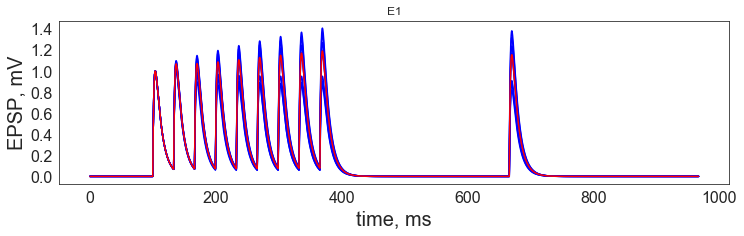

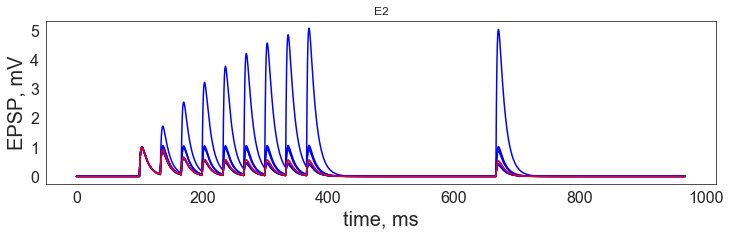

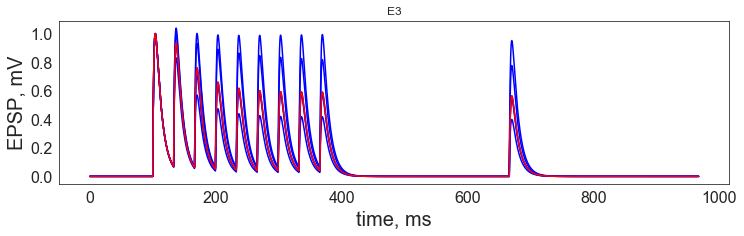

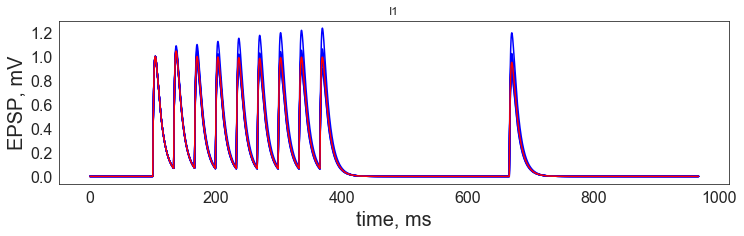

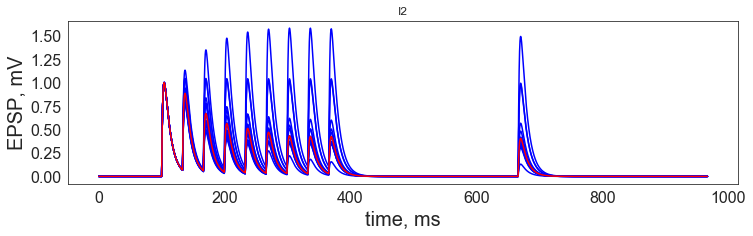

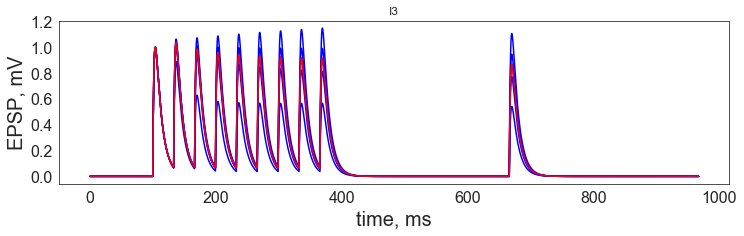

In [191]:
sx = 12
sy=3

for pol in ['ex', 'inh']:
    for stype in ['dtype_1', 'dtype_2', 'dtype_3']:
        #df_pol_stype=df_Stp_type_p.loc[(df_Stp_type_p.loc[:,'polarity']==pol)&(df_Stp_type_p.loc[:,stype]>=0.7),:]
        df_pol_stype=df_Stp_type_p.loc[(df_Stp_type_p.loc[:,'polarity']==pol)&(df_Stp_type_p.loc[:,stype]==True),:]
        if df_pol_stype.shape[0]>0:
            idx = df_pol_stype.index[df_pol_stype.index[:]<53]
            epsp = EPSP2[idx,:].T
            am=np.max(epsp[0:int((100+15)/dt),:], axis=0)
            epsp =epsp/np.tile(am,[epsp.shape[0],1])
            
            f, ax =plt.subplots(figsize=(sx, sy))

            plt.plot(t_epsp,epsp,color='b')
            plt.plot(t_epsp,np.median(epsp, axis=1),color='r')
            
            #dat.hist(bins=25)
            all_syn_names=df_pol_stype.loc[idx,'name'].str.cat(sep='; ')
            
            if pol=='ex':
                npol='E'
            else:
                npol='I'
            nstype = str.split(stype, '_')[1]        
            plt.title(npol+nstype )
            plt.xticks(fontsize=16)
            plt.yticks(fontsize=16)
            plt.xlabel('time, ms',fontsize=20)
            plt.ylabel('EPSP, mV',fontsize=20)
            
            print(npol+nstype + '  synaptic pair types: ' +all_syn_names+'\n')
            
        

### Examples of distributions of An/A1 and U,D,F parameters.  Cortex

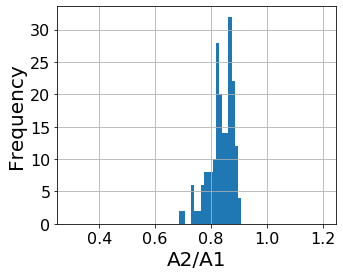

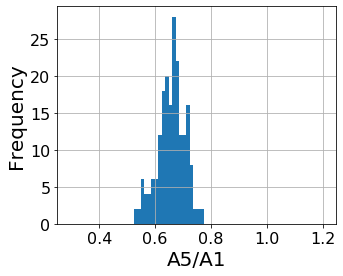

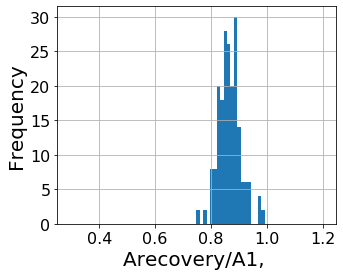

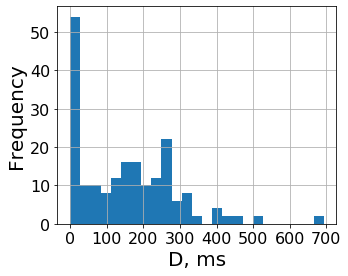

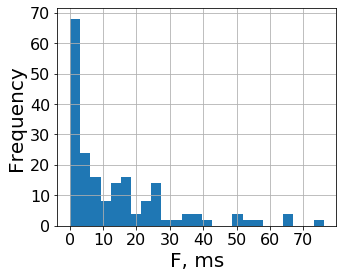

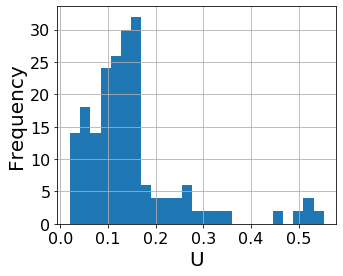

In [39]:

%matplotlib inline


#
#do_medians, do_log should be off!!!
# Nsamples = 200 !!!


## some distributions
#stp_columns

# f, ax =plt.subplots(figsize=(16, 7))
# plt.plot(ge_data.iloc[3600:3800,:].loc[:,stp_columns].transpose(),'o-')
# plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
#          rotation_mode="anchor")

#f, ax =plt.subplots(figsize=(16, 7))
stp_columns2=np.array(stp_columns)
annot_columns2 =np.array(annot_columns)
sx=5
sy=4
i0=0

for i0 in [42]: # [18,23,42] #range(0,53):
    str_syntype = ge_data.loc[i0*200,annot_columns2[[0,2,1,3]]].astype(str).str.cat(others=['_','->','_','']).str.cat()

    #print(ge_data.loc[i0*200,annot_columns[:-3]])

    ii = i0*200 + np.arange(200)
    f, ax =plt.subplots(figsize=(sx, sy))
    ge_data.iloc[ii,:].loc[:,stp_columns2[0]].hist(bins=20)
    #plt.title(str(i0)+ '  '+str_syntype + '  ' +stp_columns2[0])
    plt.xlim((0.25,1.25)) 
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('A2/A1',fontsize=20)
    plt.ylabel('Frequency',fontsize=20)

    f, ax =plt.subplots(figsize=(sx, sy))
    ge_data.iloc[ii,:].loc[:,stp_columns2[3]].hist(bins=20)
    #plt.title(str(i0)+ '  '+str_syntype + '  ' +stp_columns2[3])
    plt.xlim((0.25,1.25))
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('A5/A1',fontsize=20)
    plt.ylabel('Frequency',fontsize=20)

    f, ax =plt.subplots(figsize=(sx, sy))
    ge_data.iloc[ii,:].loc[:,stp_columns2[4]].hist(bins=20)
    #plt.title(str(i0)+ '  '+str_syntype + '  ' +stp_columns2[4])
    plt.xlim((0.25,1.25))
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Arecovery/A1, ',fontsize=20)
    plt.ylabel('Frequency',fontsize=20)


    f, ax =plt.subplots(figsize=(sx, sy))
    dat=ge_data.iloc[ii,:].loc[:,'tD'].map(float)
    dat=dat.loc[dat.loc[:]<800]
    dat.hist(bins=25)
    #plt.title(str(i0)+ '  '+str_syntype + '  ' +'D')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('D, ms',fontsize=20)
    plt.ylabel('Frequency',fontsize=20)

    f, ax =plt.subplots(figsize=(sx, sy))
    #ge_data.iloc[ii,:].loc[:,'tF'].map(float).hist(bins=25)
    dat=ge_data.iloc[ii,:].loc[:,'tF'].map(float)
    dat=dat.loc[dat.loc[:]<5500]
    dat.hist(bins=25)
    #plt.title(str(i0)+ '  '+str_syntype + '  ' +'F')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('F, ms',fontsize=20)
    plt.ylabel('Frequency',fontsize=20)

    f, ax =plt.subplots(figsize=(sx, sy))
    #ge_data.iloc[ii,:].loc[:,'p0'].map(float).hist(bins=25)
    dat=ge_data.iloc[ii,:].loc[:,'p0'].map(float)
    dat=dat.loc[dat.loc[:]<1]
    dat.hist(bins=25)
    #plt.title(str(i0)+ '  '+str_syntype + '  ' +'U')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('U',fontsize=20)
    plt.ylabel('Frequency',fontsize=20)

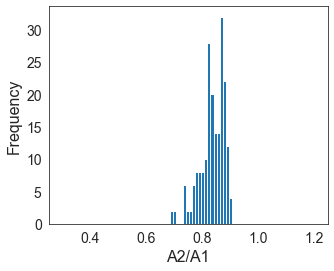

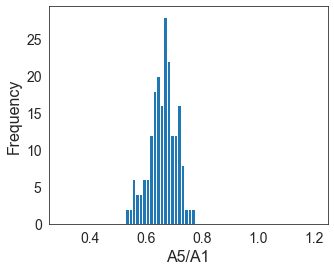

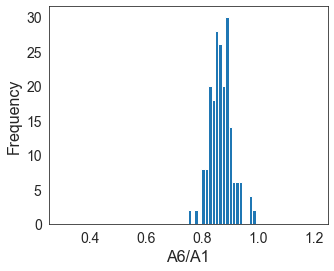

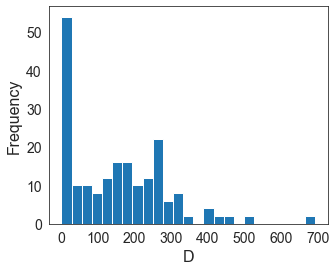

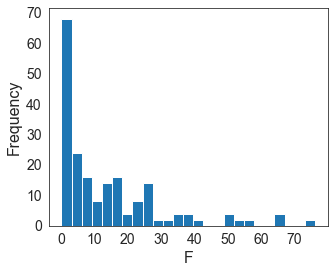

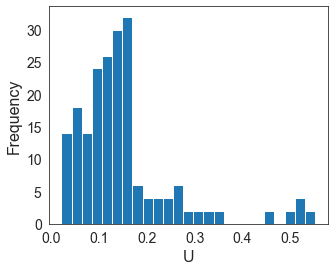

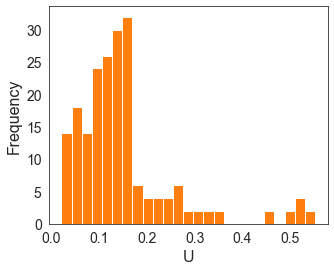

In [91]:
%matplotlib inline

#
#do_medians, do_log should be off!!!
#


## some distributions
#stp_columns

# f, ax =plt.subplots(figsize=(16, 7))
# plt.plot(ge_data.iloc[3600:3800,:].loc[:,stp_columns].transpose(),'o-')
# plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
#          rotation_mode="anchor")

#f, ax =plt.subplots(figsize=(16, 7))
stp_columns2=np.array(stp_columns)
annot_columns2 =np.array(annot_columns)
sx=5
sy=4
i0=0

for i0 in [42]: # [18,23,42] #range(0,53):
    str_syntype = ge_data.loc[i0*200,annot_columns2[[0,2,1,3]]].astype(str).str.cat(others=['_','->','_','']).str.cat()

    #print(ge_data.loc[i0*200,annot_columns[:-3]])

    ii = i0*200 + np.arange(200)
    f, ax =plt.subplots(figsize=(sx, sy))
    ge_data.iloc[ii,:].loc[:,stp_columns2[0]].hist(bins=20)
    #plt.title(str(i0)+ '  '+str_syntype + '  ' +stp_columns2[0])
    plt.xlim((0.25,1.25))
    plt.xlabel(stp_columns2[0],fontsize=16)
    plt.ylabel('Frequency',fontsize=16)
    plt.setp(ax.get_xticklabels(),fontsize=14)
    plt.setp(ax.get_yticklabels(),fontsize=14)
    ax.grid(b=False)

    f, ax =plt.subplots(figsize=(sx, sy))
    ge_data.iloc[ii,:].loc[:,stp_columns2[3]].hist(bins=20)
    #plt.title(str(i0)+ '  '+str_syntype + '  ' +stp_columns2[3])
    plt.xlim((0.25,1.25))
    plt.xlabel(stp_columns2[3],fontsize=16)
    plt.ylabel('Frequency',fontsize=16)
    plt.setp(ax.get_xticklabels(),fontsize=14)
    plt.setp(ax.get_yticklabels(),fontsize=14)
    ax.grid(b=False)

    f, ax =plt.subplots(figsize=(sx, sy))
    ge_data.iloc[ii,:].loc[:,stp_columns2[4]].hist(bins=20)
    #plt.title(str(i0)+ '  '+str_syntype + '  ' +stp_columns2[4])
    plt.xlim((0.25,1.25))
    plt.xlabel(stp_columns2[4],fontsize=16)
    plt.ylabel('Frequency',fontsize=16)
    plt.setp(ax.get_xticklabels(),fontsize=14)
    plt.setp(ax.get_yticklabels(),fontsize=14)
    ax.grid(b=False)
    


    f, ax =plt.subplots(figsize=(sx, sy))
    dat=ge_data.iloc[ii,:].loc[:,'tD'].map(float)
    dat=dat.loc[dat.loc[:]<800]
    dat.hist(bins=25)
    #plt.title(str(i0)+ '  '+str_syntype + '  ' +'tD')
    plt.xlabel('D',fontsize=16)
    plt.ylabel('Frequency',fontsize=16)
    plt.setp(ax.get_xticklabels(),fontsize=14)
    plt.setp(ax.get_yticklabels(),fontsize=14)
    ax.grid(b=False)

    f, ax =plt.subplots(figsize=(sx, sy))
    #ge_data.iloc[ii,:].loc[:,'tF'].map(float).hist(bins=25)
    dat=ge_data.iloc[ii,:].loc[:,'tF'].map(float)
    dat=dat.loc[dat.loc[:]<5500]
    dat.hist(bins=25)
    #plt.title(str(i0)+ '  '+str_syntype + '  ' +'tF')
    plt.xlabel('F',fontsize=16)
    plt.ylabel('Frequency',fontsize=16)
    plt.setp(ax.get_xticklabels(),fontsize=14)
    plt.setp(ax.get_yticklabels(),fontsize=14)
    ax.grid(b=False)

    f, ax =plt.subplots(figsize=(sx, sy))
    #ge_data.iloc[ii,:].loc[:,'p0'].map(float).hist(bins=25)
    dat=ge_data.iloc[ii,:].loc[:,'p0'].map(float)
    dat=dat.loc[dat.loc[:]<1]
    dat.hist(bins=25)
    #plt.title(str(i0)+ '  '+str_syntype + '  ' +'p0')
    plt.xlabel('U',fontsize=16)
    plt.ylabel('Frequency',fontsize=16)
    plt.setp(ax.get_xticklabels(),fontsize=14)
    plt.setp(ax.get_yticklabels(),fontsize=14)
    ax.grid(b=False)
    
    f, ax =plt.subplots(figsize=(sx, sy))
    ge_data.iloc[ii,:].loc[:,'p0'].map(float).hist(bins=25)
    dat=ge_data.iloc[ii,:].loc[:,'p0'].map(float)
    dat=dat.loc[dat.loc[:]<1]
    dat.hist(bins=25)
    #plt.title(str(i0)+ '  '+str_syntype + '  ' +'p0'
    plt.xlabel('U',fontsize=16)
    plt.ylabel('Frequency',fontsize=16)
    plt.setp(ax.get_xticklabels(),fontsize=14)
    plt.setp(ax.get_yticklabels(),fontsize=14)
    plt.grid(b=False)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

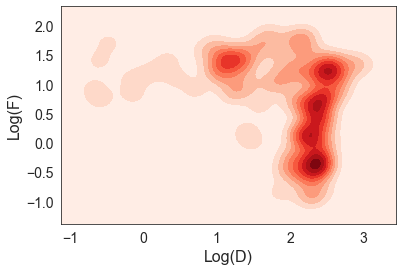

In [97]:
# library & dataset
import seaborn as sns
#df = sns.load_dataset('iris')
 
# Basic 2D density plot
sns.set_style("white")
#sns.kdeplot(df.sepal_width, df.sepal_length)
#sns.plt.show()
 
# Custom it with the same argument as 1D density plot
dat=ge_data.iloc[ii,:].loc[:,'tD'].map(float)
dat2=ge_data.iloc[ii,:].loc[:,'tF'].map(float)
dat3=ge_data.iloc[ii,:].loc[:,'p0'].map(float)
sns.kdeplot(np.log10(dat), np.log10(dat2), cmap="Reds", shade=True, bw=.15) #, log_scale=True) #, log_scale=True

plt.xlabel('Log(D)',fontsize=16)
plt.ylabel('Log(F)',fontsize=16)
plt.setp(plt.gca().get_xticklabels(),fontsize=14)
plt.setp(plt.gca().get_yticklabels(),fontsize=14)
 
# Some features are characteristic of 2D: color palette and wether or not color the lowest range
#sns.kdeplot(df.sepal_width, df.sepal_length, cmap="Blues", shade=True, shade_lowest=True, )
##sns.plt.show()


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

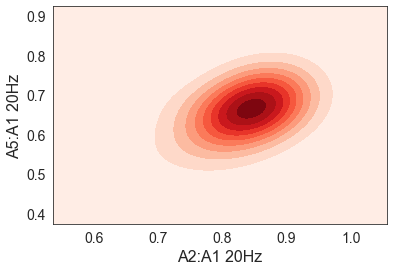

In [98]:
# Basic 2D density plot
sns.set_style("white")
#sns.kdeplot(df.sepal_width, df.sepal_length)
#sns.plt.show()
 
# Custom it with the same argument as 1D density plot
dat=ge_data.iloc[ii,:].loc[:,stp_columns2[0]].map(float)
dat2=ge_data.iloc[ii,:].loc[:,stp_columns2[3]].map(float)
dat3=ge_data.iloc[ii,:].loc[:,stp_columns2[4]].map(float)
sns.kdeplot((dat), (dat2), cmap="Reds", shade=True, bw=.05)
plt.xlabel('A2:A1 20Hz',fontsize=16)
plt.ylabel('A5:A1 20Hz',fontsize=16)
plt.setp(plt.gca().get_xticklabels(),fontsize=14)
plt.setp(plt.gca().get_yticklabels(),fontsize=14)
#ge_data.iloc[ii,:].loc[:,stp_columns2[0]].hist(bins=20)

Automatically created module for IPython interactive environment


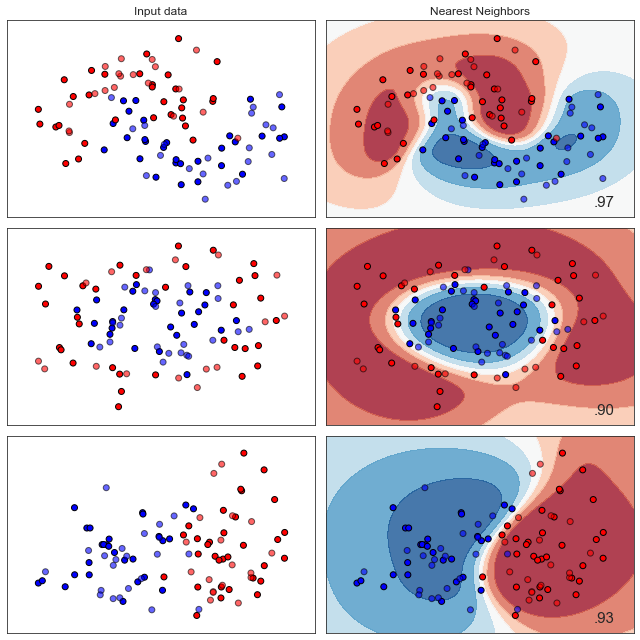

In [102]:
print(__doc__)


# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

classifiers = [
    GaussianProcessClassifier(1.0 * RBF(1.0)),
]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(9, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

In [43]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [39]:
ge_data_h.shape

(8000, 10451)

In [40]:
ge_data.shape

(10600, 10459)

In [41]:
X_c.shape

(10600, 10427)

In [42]:
X_h.shape

(8000, 10427)

In [43]:
set(ge_data.columns).difference(set(ge_data_h.columns))

{'A1', 'A2', 'dd', 'dp', 'dp0', 'tDmin', 't_FDR', 't_SMR'}

##
##
##  combine cortex and hippocampus datasets 
##
##

In [44]:
# ge_data_h = ge_data
# X_h = X
# y_h = y
# annot_columns_h = annot_columns
# ge_columns_h = ge_columns
# stp_columns_h = stp_colum

X = np.concatenate([X_c, X_h],axis=0)
y = np.concatenate([y_c, y_h],axis=0)

print(X_h.shape)
print(X_c.shape)
X.shape

(8000, 10427)
(10600, 10427)


(18600, 10427)

In [46]:
Xan = pd.DataFrame(X[0::200,0:6])
Xan.to_excel('all_annotations.xlsx') 

VISp           53
Hippocampus    34
dtype: int64

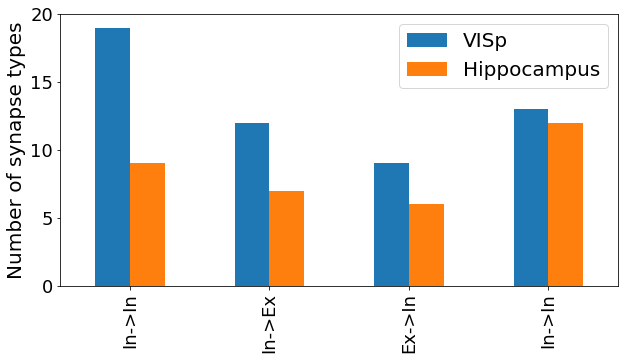

In [47]:
Xan2 = pd.DataFrame([[16+3,8+4,8+1,11+2],[9,7,6,12]],columns = ['In->In','In->Ex','Ex->In','In->In'],
                    index=['VISp','Hippocampus']).T

#import matplotlib.pyplot as plt
f, ax =plt.subplots(figsize=(10, 5))
#    plt.title(str(i0)+ '  '+str_syntype + '  ' +stp_columns2[3])
#    plt.xlim((0.25,1.25))

Xan2.plot(kind = 'bar',ax=ax)
plt.ylim([0,20])
plt.xticks(fontsize=18)
plt.yticks(ticks=[0,5,10,15,20],fontsize=18)
plt.ylabel('Number of synapse types',fontsize=20)
#plt.xlabel('Synapse type',fontsize=20)
plt.legend(fontsize=20)
#print(set(n_stp_cells.index).difference(set(i2)))
#n_stp_cells4.sum()



Xan2.sum()

In [48]:
#pd.DataFrame(X).to_excel('temp.xlsx')

In [49]:
'cell_type2_post', 'layer_post'   , 'cell_type2_pre', 'layer_pre'

('cell_type2_post', 'layer_post', 'cell_type2_pre', 'layer_pre')

In [45]:
import time
t1 = time.time()
subclasses2_hipp = ['e_dg','e_ca','e_e','Pvalb_h','Sst_h','Vip','Lamp5_h','Cck_h']
subclasses3_hipp = [['DG','CA3','CA3 ventral'],
                    ['CA1','CA1 ventral'],
                    ['EC'],
                    ['PV','Pvalb','PVBC','AAC'],
                    ['Sst','HIPP','O-LM','O-Bi'],
                    ['Vip','IS3'],
                    ['Lamp5','Ivy cell','Ivy cell type2','NGF','NGF type2'],
                    ['Cck','CCKBC','HICAP','CCK_DTI']]


ge_data_h_subcl = pd.DataFrame(np.zeros((ge_data_h.shape[0],4)),columns = ['name_long_pre','name_long_post',
                                                                           'subclass_pre','subclass_post'])
ge_data_h_subcl.index = ge_data_h.index
precol = ['cell_type2_pre', 'layer_pre'] #ge_data_h.columns[[1,5]]
postcol = ['cell_type2_post', 'layer_post' ] # ge_data_h.columns[[2,6]]


all_type_1 = ge_data_h.loc[:,'cell_type2_pre']+ ' ' + ge_data_h.loc[:,'cre_line_pre'] +' '+ge_data_h.loc[:,'layer_pre']
all_type_2 = ge_data_h.loc[:,'cell_type2_post']+ ' ' + ge_data_h.loc[:,'cre_line_post'] +' '+ge_data_h.loc[:,'layer_post']

ge_data_h_subcl.loc[:,'name_long_pre'] = all_type_1
ge_data_h_subcl.loc[:,'name_long_post'] = all_type_2

for j in range(len(subclasses3_hipp)): 
    is_in_pre = ge_data_h.loc[:,precol[0]].isin(subclasses3_hipp[j])
    is_in_post = ge_data_h.loc[:,postcol[0]].isin(subclasses3_hipp[j])
    ge_data_h_subcl.loc[is_in_pre,'subclass_pre'] =subclasses2_hipp[j]
    ge_data_h_subcl.loc[is_in_post,'subclass_post'] =subclasses2_hipp[j] 
    
t2=time.time()
print('elapsed time : '+str(t2-t1))
ge_data_h_subcl    

elapsed time : 0.19841384887695312


,name_long_pre,name_long_post,subclass_pre,subclass_post
0,PV none DG,PV none DG,Pvalb_h,Pvalb_h
1,PV none DG,PV none DG,Pvalb_h,Pvalb_h
2,PV none DG,PV none DG,Pvalb_h,Pvalb_h
3,PV none DG,PV none DG,Pvalb_h,Pvalb_h
4,PV none DG,PV none DG,Pvalb_h,Pvalb_h
5,PV none DG,PV none DG,Pvalb_h,Pvalb_h
6,PV none DG,PV none DG,Pvalb_h,Pvalb_h
7,PV none DG,PV none DG,Pvalb_h,Pvalb_h
8,PV none DG,PV none DG,Pvalb_h,Pvalb_h
9,PV none DG,PV none DG,Pvalb_h,Pvalb_h


In [46]:
all_types = []
all_types2 = []
columns = ['cell_type2_pre','cell_type2_post','layer_pre','layer_post','cre_line_pre','cre_line_post']
for i in ge_data.index:
    all_type=''
    all_type2=''
    for j in range(3):
        sj = str(ge_data.loc[i,columns[2*j]])
        if sj=='MC':
            sj='Sst'    
        all_type = all_type  +' '+sj
        
    for j in range(3):
        sj = str(ge_data.loc[i,columns[2*j+1]])
        if sj=='MC':
            sj='Sst'    
        all_type2 = all_type2 +' '+sj    
    all_types = all_types  +[str.lower(all_type)]  
    all_types2 = all_types2  +[str.lower(all_type2)]   

all_types =  pd.DataFrame(all_types, columns=['pre'])
all_types2 =  pd.DataFrame(all_types2, columns=['post'])
all_types = pd.concat([all_types,all_types2], axis=1)

subclasses = pd.Series([ 'Sst','Pvalb','Vip','ev_l23','ev_l4','ev_l56','ev_l56'])
subclasses2 = pd.Series(['sst','pvalb','vip','l2',    'l4',   'l5',    'l6'])
subclasses2_visp =subclasses2   

subclasses_visp_1 = pd.DataFrame(pd.unique(all_types.loc[:,'pre'].values))
subclasses_visp_2 = pd.DataFrame(pd.unique(all_types.loc[:,'post'].values))
# subclasses =  pd.DataFrame(subclasses,columns=['pre', 'post'] )
# subclasses_visp = pd.concat([subclasses_visp1, subclasses], axis=1)

ge_data_c_subcl = pd.DataFrame(np.tile(all_types,(1,2)))
ge_data_c_subcl.columns=['name_long_pre','name_long_post','subclass_pre','subclass_post']
for i in range(subclasses_visp_1.shape[0]):
    type_name = str.lower(subclasses_visp_1.loc[i,0])
#     is_in=[]
#     for si in subclasses2:
#         is_in = is_in +[ss.contains(si)]
#     is_in=np.nonzero(np.array(is_in))[0][0] 
#     subcl_name = subclasses[is_in]
    
    for ii,si in enumerate(subclasses2):
        if si in type_name:
            subcl_name = subclasses[ii]
            break
    ge_data_c_subcl.loc[ge_data_c_subcl.loc[:,'name_long_pre']==type_name,'subclass_pre'] =subcl_name
    
for i in range(subclasses_visp_2.shape[0]):
    type_name = str.lower(subclasses_visp_2.loc[i,0])
    for ii,si in enumerate(subclasses2):
        if si in type_name:
            subcl_name = subclasses[ii]
            break
    ge_data_c_subcl.loc[ge_data_c_subcl.loc[:,'name_long_post']==type_name,'subclass_post'] =subcl_name    

#     ge_data_c_subcl.loc[ge_data_c_subcl.loc[:,'name_long'].isin([subclasses_visp.loc[i,0]]),'subclass_pre'] =subclasses_visp.loc[i,'pre']
#     ge_data_c_subcl.loc[ge_data_c_subcl.loc[:,'name_long'].isin([subclasses_visp.loc[i,0]]),'subclass_post'] =subclasses_visp.loc[i,'post']

#ge_data_c_subcl    

In [47]:
ge_data_subcl = pd.concat([ge_data_c_subcl, ge_data_h_subcl],sort=False)
subclasses2 =pd.concat([subclasses, pd.Series(subclasses2_hipp)])
ge_data_subcl

,name_long_pre,name_long_post,subclass_pre,subclass_post
0,pv l4 pvalb-ires-cre,pc l4 pc,Pvalb,ev_l4
1,pv l4 pvalb-ires-cre,pc l4 pc,Pvalb,ev_l4
2,pv l4 pvalb-ires-cre,pc l4 pc,Pvalb,ev_l4
3,pv l4 pvalb-ires-cre,pc l4 pc,Pvalb,ev_l4
4,pv l4 pvalb-ires-cre,pc l4 pc,Pvalb,ev_l4
5,pv l4 pvalb-ires-cre,pc l4 pc,Pvalb,ev_l4
6,pv l4 pvalb-ires-cre,pc l4 pc,Pvalb,ev_l4
7,pv l4 pvalb-ires-cre,pc l4 pc,Pvalb,ev_l4
8,pv l4 pvalb-ires-cre,pc l4 pc,Pvalb,ev_l4
9,pv l4 pvalb-ires-cre,pc l4 pc,Pvalb,ev_l4
